In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [4]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [5]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [6]:
np.set_printoptions(precision=2, suppress=True)

In [7]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = os.path.expandvars("$HOME/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta")
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /Users/michal/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945


In [8]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [9]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [10]:
LEVEL = 30

In [11]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [12]:
np.set_printoptions(precision=3, suppress=True)

In [13]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [14]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [15]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [16]:
class ShortCommonDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [36]:
def make_fussy(FUSSY_THRESHOLD):

    class FussyGraphDPLL(DPLL):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1

            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            # major hack - should be done via exceptions
            if self.number_of_runs >= 1e3:
                return None

            sug_var = self.suggest_neural(cnf)
            if sug_var is None:
                print("Fussy cut")
                return None

            sug_cnf = cnf.set_var(sug_var)
            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None

        def suggest_neural(self, input_cnf: CNF):
            clause_num = len(input_cnf.clauses)
            var_num = max(input_cnf.vars)
            inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)

            policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})

            best_prob = 0.0
            best_svar = None
            for var in input_cnf.vars:
                for svar in [var, -var]:
                    svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                    print(svar, svar_prob, best_prob, file=logfile)
                    if svar_prob > best_prob:
                        best_prob = svar_prob
                        best_svar = svar


            if best_prob < FUSSY_THRESHOLD:
                print("I", input_cnf)
                print("P", policy_probs)
                return None
            else:
                return best_svar
    FussyGraphDPLL.__name__ = "FussyGraphDPLL{}".format(FUSSY_THRESHOLD)
    return FussyGraphDPLL


class GraphDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        # major hack - should be done via exceptions
        if self.number_of_runs >= 1e3:
            return None
        
        sug_var = self.suggest_neural(cnf)
        if sug_var is None:
            print("Fussy cut")
            return None
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
                
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
                    
        return best_svar

In [37]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within 1e3 steps solved {} problems out of {}".format(solved, len(sats)))
    return steps, errors

In [38]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [44]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, make_fussy(0.7))
    compute_and_print_steps(sats, make_fussy(0.75))
    compute_and_print_steps(sats, make_fussy(0.8))
    compute_and_print_steps(sats, make_fussy(0.85))
    compute_and_print_steps(sats, make_fussy(0.9))
    logfile.flush()

  0%|          | 0/30 [00:00<?, ?it/s]

We have generated 30 formulas


100%|██████████| 30/30 [00:53<00:00,  1.68s/it]


Within 1e3 steps solved 22 problems out of 30
#Sats: 22; avg step: 212.23; stdev step: 328.87; avg error: 0.91; stdev error: 1.44


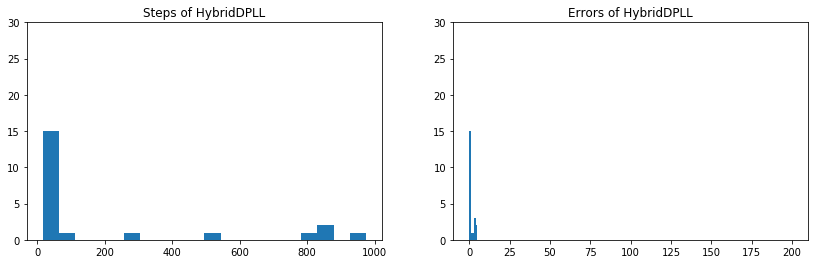

  0%|          | 0/30 [00:00<?, ?it/s]

I (g|~i|q)&(b|d|i|s)&(~h|o|~n|~b)&(m|c|~n|~e)&(s|~l|~r)&(~a|l|~h|r|n|~i)&(e|~r|~c)&(~t|b|~r)&(m|~p|~j|d|~a)&(o|~m|~c)&(j|o|~n|t|~g|~c)&(j|i|p|r)&(~d|~g|o|~m)&(m|n|l)&(s|~l|n|t|~g)&(~i|~n|~j)&(~c|t|f)&(h|~j|~m|~i|a|~e|c|~b|~l|~g|o)&(j|r|~m|~l|~b)&(p|~f|j)&(s|~a|n|o)&(~m|~d|s|a|~t|b)&(b|j|~t|l|n|o|q|~g|~f|~d|~c)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(r|m|s)&(q|~n|~p|i|r|~c)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(i|~b|g)&(~l|~g|~f)&(~g|t|~c|f)&(~t|~j|~s|e)&(a|e|i|~t)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(j|~r|~e|t|~s|p|~n|i)&(m|p|~a)&(f|g|p|~s)&(~g|~l|~p)&(~l|~c|~b)&(e|i|~t|o|s|~l|~d|~c|~b)&(m|~g|~j|r|~l)&(i|~j|f|~d|~a|r)&(~d|~h|~l|b)&(m|~s|l)&(r|~o|l|j|~t)&(~d|m|j|~i)&(h|~p|~o|~n)&(~t|~f|n)&(c|~i|h|~s)&(~j|~q|e)&(~p|~q|b|m|~d|l|s|~o|~e)&(~q|~a|~e|~b|g)&(~e|c|q|p|~s)&(c|g|~l|p|~e|m)&(~j|~i|~l|r|t)&(n|~e|s)&(i|~n|p)&(l|p|e|~o|r)&(~n|t|j)&(~p|~l|c|~i)&(i|o|~p|~q|~n|~e)&(p|~j|b|~n|c|~d|~a)&(~s|d|~i)&(~m|~o|~j|~i|~l)&(~b|~o|i|~s|~q|~h|~f)&(p|~e)&(p|~o|s)&(d|s|e|~n|c)&(~r|g|~e)&(t|c|d)&(c|~n|~o|j)&(t|~e|~o)&(

  3%|▎         | 1/30 [00:14<07:02, 14.58s/it]

I (o)&(~o)&(o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (m)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (b)&(b|o)&(~b|o)&(~o|~b)&(p)&(~p)
P [[[0.528 0.528]
  [0.351 0.211]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528

 10%|█         | 3/30 [00:29<04:39, 10.35s/it]

I (j)&(p|~j)&(j)&(~j)&(~p|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.395 0.123]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.433 0.433]]]
Fussy cut
I (a)&(a)&(~a)&(~a)
P [[[0.224 0.224]]]
Fussy cut
I (~p|d)&(~d)&(d|~a)&(a|p|~d)&(d)&(~p|~d)
P [[[0.314 0.383]
  [0.528 0.528]
  [0.528 0.528]
  [0.227 0.276]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.28  0.644]]]
Fussy cut
I (e)&(e|~a)&(e)&(a)&(~e)&(~a)&(~a)&(a|~e)
P [[[0.19  0.305]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.305 0.19 ]]]
Fussy cut
I (q|d|~a)&(e)&(q)&(e|~a)&(~d|~q)&(q|~e|d)&(e)&(d|~a|~q)&(a|~d)&(~e)&(d|e)&(a)&(~e|~q)&(~a)&(a|~e)&(a|~e|d)
P [[[0.289 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.526 0.26 ]
  [0.273 0.287]
  [0.528 0.

 30%|███       | 9/30 [00:45<00:50,  2.38s/it]

I (t)&(p|t)&(~p|t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.095]]]
Fussy cut
I (t)&(p|t)&(~p|t)&(t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.087 0.326]]]
Fussy cut
I (p)&(~p|c)&(~p|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]

I (~n|~m)&(p)&(~n)&(~n|m)&(~n|~m)&(p|n)&(~p)&(~p)&(n)&(~p|n)&(p|m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.321 0.428]
  [0.274 0.298]
  [0.528 0.528]
  [0.214 0.321]]]
Fussy cut
I (~n|~m)&(m)&(p)&(~n)&(~n|m)&(~n|~m)&(p|n)&(~p)&(~p)&(n)&(~p|n)&(~m)&(p|m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.284 0.32 ]
  [0.306 0.333]
  [0.528 0.528]
  [0.21  0.342]]]
Fussy cut
I (~n|~m)&(m)&(~n)&(~n|m)&(~n|~m)&(n)&(n)&(~m)&(~m)&(m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.181 0.399]
  [0.267 0.234]]]
Fussy cut
I (~n)&(c)&(~n)&(

 33%|███▎      | 10/30 [00:58<01:49,  5.46s/it]

I (j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut


 37%|███▋      | 11/30 [00:59<01:16,  4.02s/it]

I (p)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (p)&(g)&(~p)&(g)&(~p|g)&(~g)&(~p|g)&(~p|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.547 0.05 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.06 ]]]
Fussy cut
I (h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~d)&(d)&(h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(p|l)&(~p|l)&(l)&(l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

 40%|████      | 12/30 [01:12<02:04,  6.90s/it]

I (~g|~l)&(l)&(g)&(l)&(l)&(~l)&(~g)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.17  0.226]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.336 0.147]]]
Fussy cut
I (~t)&(t|f|~r)&(t|f)&(~f|t)&(r|~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.559 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.404 0.566]
  [0.528 0.528]
  [0.251 0.332]]]
Fussy cut
I (~t)&(t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~f)&(t|f)&(~f|t)&(~t|f)
P [[[0.52

 43%|████▎     | 13/30 [01:13<01:28,  5.23s/it]

I (~g)&(~g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (q)&(q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (a)&(g)&(~g)&(~a|g)&(g)&(~g)&(~a)&(a)&(~a)
P [[[0.185 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]]]
Fussy cut
I (~m)&(~m)&(m)&(~m)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.166 0.178]]]
Fussy cut
I (~e)&(~e|l)&(l|e)&(l|~e)&(~l)&(e)&(~e|l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.387 0.417]
  [0

 47%|████▋     | 14/30 [01:27<02:01,  7.59s/it]

I (l|~q)&(~l|~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (~q)&(q)&(~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (e)&(e)&(e)&(~e)&(~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (~q)&(~q)&(q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.52

I (~k|o)&(~o|~k)&(o)&(k)&(~o)&(~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.692 0.198]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.283 0.283]]]
Fussy cut
I (o)&(e)&(o)&(~e)&(~o)&(o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (s)&(e)&(k|e)&(~e|~k)&(k|~e)&(~s)&(s|~k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.486 0.24 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.095 0.58 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.511 0.544]]]
Fussy cut
I (e|~q)&(e|~q)&(~e)&(q|e)&(q|e)
P [[[0.528 0.528]
  [0.528

 50%|█████     | 15/30 [01:40<02:18,  9.27s/it]

I (o)&(~o|c)&(~o|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (f|o)&(f)&(o)&(f)&(~o|f)&(~o|f)&(~o)&(f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.566 0.026]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.071 0.298]]]
Fussy cut
I (f)&(q|~f)&(n)&(~q)&(~f|~n|~q)&(n|~q)&(f|~q)&(f)&(~n)&(f)&(n)&(~f)&(q|f)&(q|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.456 0.67 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.279 0.689]
  [0.528 0.528]
  [0.528 0.528]
  [0.111 0.594]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.

I (~f)&(f)&(~f)&(f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~g|~n|~r)&(r)&(~n|~r|g)&(~g)&(~g)&(~n)&(n)&(~n|g)&(r|~n)&(r|n)&(n|g)&(~r)&(n|~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.217 0.691]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.317 0.313]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.299 0.292]]]
Fussy cut
I (~r|~q)&(r|~q)&(q)&(~q)&(q)&(~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.188 0.205]
  [0.35  0.35 ]]]
Fussy cut
I (~r|o)&(r|~q)&(q)&(~q)&(~q)&(q|o)&(~r|o)&(~q)&(~q)&(~o|~r)&(r)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528

 57%|█████▋    | 17/30 [01:51<01:30,  6.98s/it]

I (~e)&(i|j|~t|~e)&(n|e|~i|j)&(i)&(i)&(i|j|n)&(i|j)&(~t|~j|n)&(~j)&(e|j|~t|~n|~i)&(~n|t)&(~e|~j)&(n|~j)&(e|i|n|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.239 0.511]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.692 0.097]
  [0.17  0.682]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.512 0.204]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.536 0.265]]]
Fussy cut
I (~e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~e)&(e|n)&(e)&(~n|e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.095]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]]]
Fussy cut
I (~e)&(~e)&(e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (r)&(~r)&(~r)&(r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]


I (~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (o)&(~o)&(~o)&(~k)&(~k)&(o)&(k)&(~o|k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.195 0.303]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.166 0.323]]]
Fussy cut
I (o)&(~o)&(o)&(~o)&(~k)&(~k)&(o)&(k)&(~o|k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.194 0.256]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.25  0.227]]]
Fussy cut
I (~r)&(~r)&(r)&(r)&(r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

 60%|██████    | 18/30 [02:03<01:42,  8.55s/it]

I (l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.095 0.681]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (r)&(r)&(r)&(~r)&(~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

 70%|███████   | 21/30 [02:18<00:46,  5.19s/it]

I (i)&(~g)&(g)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~c)&(c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(~c|~j)&(c)&(~c)&(j|c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.249 0.249]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.367 0.367]]]
Fussy cut
I (~p)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.52

 73%|███████▎  | 22/30 [02:29<00:56,  7.08s/it]

I (~r)&(r)&(n|~r)&(r)&(~r)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.456 0.343]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.185 0.252]]]
Fussy cut
I (~r)&(~n)&(n|~r)&(r)&(~r)&(~n)&(r)&(n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.185 0.294]]]
Fussy cut


 83%|████████▎ | 25/30 [02:31<00:13,  2.80s/it]

I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (~n)&(n)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]

 90%|█████████ | 27/30 [02:36<00:07,  2.49s/it]

I (~o)&(~o|~c)&(~o)&(c|~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.326 0.087]]]
Fussy cut
I (m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (i)&(~e|m)&(i)&(~m)&(~m|i)&(i)&(e)&(~i)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.293 0.128]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.53  0.4  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.408]]]
Fussy cut
I (m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.52

 93%|█████████▎| 28/30 [02:49<00:11,  5.59s/it]

I (j)&(~j)&(j)&(j)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.178 0.166]]]
Fussy cut
I (f)&(~f)&(f)&(~f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~c|f)&(~j)&(~f)&(j|c)&(f|~j)&(~l|f)&(j|l)&(j)&(~f)&(~f|c)&(j|f)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.58  0.196]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.371]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.312 0.222]
  [0.528 0.528]
  [0.315 0.354]]]
Fussy cut
I (j)&(j|~q)&(~j)&(q|~j)&(j)&(j)&(j|~q)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.475 0.085]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.438 0.177]]]
Fussy cut
I (j|~q)&(~j)&(~j)&(q|~j)&(j|~q)&(j)&(j)
P [[[0.528 0.528

I (m)&(~m)&(~m|~j)&(m)&(~m|~j)&(o)&(m)&(~o)&(m|o)&(j)&(o)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.134 0.618]
  [0.528 0.528]
  [0.528 0.528]
  [0.206 0.054]
  [0.528 0.528]
  [0.269 0.016]]]
Fussy cut
I (f|~j)&(f)&(~e|~j)&(j)&(f|~j)&(~f|e)&(~e|f)&(~j)&(~f)&(e|~j)&(e|f)&(~f|o)&(~o|~e)&(o)&(~o)&(~j)&(j)&(~o|f)&(~o|f)&(~f)&(~f|o)&(o)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.369 0.357]
  [0.268 0.291]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.342 0.55 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.284 0.233]]]
Fussy cut
I (f|~j)&(~f)&(~f)&(f)&(f)&(j)&(j|f)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.331 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.584 0.174]]]
Fussy cut
I (~j)&(~j)&(o)&(j)&(j)&(j)&(~o)&(~o)&(o)
P [[[0.528 0.528]
  [0.528 0

100%|██████████| 30/30 [03:03<00:00,  5.67s/it]


Within 1e3 steps solved 18 problems out of 30
#Sats: 18; avg step: 86.50; stdev step: 190.14; avg error: 0.17; stdev error: 0.37


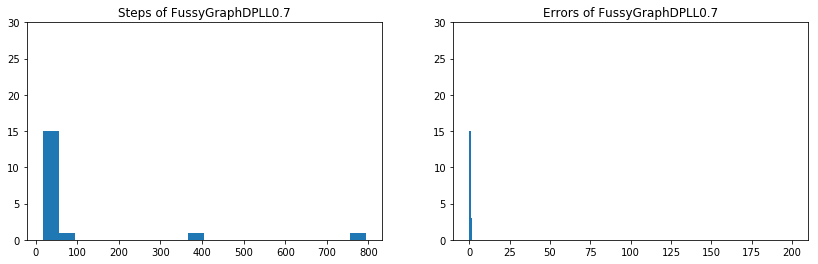

  0%|          | 0/30 [00:00<?, ?it/s]

I (g|~i|q)&(b|d|i|s)&(~h|o|~n|~b)&(m|c|~n|~e)&(s|~l|~r)&(~a|l|~h|r|n|~i)&(e|~r|~c)&(~t|b|~r)&(m|~p|~j|d|~a)&(o|~m|~c)&(j|o|~n|t|~g|~c)&(j|i|p|r)&(~d|~g|o|~m)&(m|n|l)&(s|~l|n|t|~g)&(~i|~n|~j)&(~c|t|f)&(h|~j|~m|~i|a|~e|c|~b|~l|~g|o)&(j|r|~m|~l|~b)&(p|~f|j)&(s|~a|n|o)&(~m|~d|s|a|~t|b)&(b|j|~t|l|n|o|q|~g|~f|~d|~c)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(r|m|s)&(q|~n|~p|i|r|~c)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(i|~b|g)&(~l|~g|~f)&(~g|t|~c|f)&(~t|~j|~s|e)&(a|e|i|~t)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(j|~r|~e|t|~s|p|~n|i)&(m|p|~a)&(f|g|p|~s)&(~g|~l|~p)&(~l|~c|~b)&(e|i|~t|o|s|~l|~d|~c|~b)&(m|~g|~j|r|~l)&(i|~j|f|~d|~a|r)&(~d|~h|~l|b)&(m|~s|l)&(r|~o|l|j|~t)&(~d|m|j|~i)&(h|~p|~o|~n)&(~t|~f|n)&(c|~i|h|~s)&(~j|~q|e)&(~p|~q|b|m|~d|l|s|~o|~e)&(~q|~a|~e|~b|g)&(~e|c|q|p|~s)&(c|g|~l|p|~e|m)&(~j|~i|~l|r|t)&(n|~e|s)&(i|~n|p)&(l|p|e|~o|r)&(~n|t|j)&(~p|~l|c|~i)&(i|o|~p|~q|~n|~e)&(p|~j|b|~n|c|~d|~a)&(~s|d|~i)&(~m|~o|~j|~i|~l)&(~b|~o|i|~s|~q|~h|~f)&(p|~e)&(p|~o|s)&(d|s|e|~n|c)&(~r|g|~e)&(t|c|d)&(c|~n|~o|j)&(t|~e|~o)&(

I (~c)&(j|~c)&(~j|~i)&(j|~c)&(~j)&(~p|~j)&(p|i)&(c)&(c)&(j|c)&(j)&(c)&(~i)&(p|~c)&(~c)&(i)&(~p|c)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.256 0.244]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.228 0.229]
  [0.318 0.235]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.579]]]
Fussy cut
I (~h)&(o)&(j|o)&(j)&(o)&(~h|~o)&(~j)&(~p|~j)&(p|~o)&(j)&(h)&(~h|~j)&(o|j|~h)&(o)&(~o)&(~h|~o)&(~j)&(~j)&(h|j|o)&(h)&(p)&(h|p)&(~j)&(h|~o|~p)&(~p|h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.36  0.266]
  [0.528 0.528]
  [0.176 0.406]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.367 0.226]
  [0.552 0.238]]]
Fussy cut
I (q|g)&(~h|r)&(e|~r|~c)&(~p|m|~j)&(~g|j|~c)&(o|~m|~c)&(m)&(j|o)&(j|~c|~q)&(o)&(p|q)&(e|~h|~o)&(r|m)&(~g|e|~m)&(h|~e|j|p)&(r|c|m)&(~p|~g|c|~e)&(p|m)&(~j|~q|e)&(~e|~q|g)&(~p|~j)&(~e)&(e|p|~o|r)&(c|~r)&(~p|q|~e

  3%|▎         | 1/30 [00:14<06:51, 14.19s/it]

I (o)&(~o)&(o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (m)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (m)&(a)&(a)&(a)&(~m)&(a|m)&(~a)
P [[[0.727 0.694]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.314 0.252]]]
Fussy cut
I (a)&(m)&(a)&(~m)&(a)&(a|m)&(~a)
P [[[0.727 0.694]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.314 

 10%|█         | 3/30 [00:28<04:30, 10.00s/it]

I (j)&(p|~j)&(j)&(~j)&(~p|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.395 0.123]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.433 0.433]]]
Fussy cut
I (a)&(a)&(~a)&(~a)
P [[[0.224 0.224]]]
Fussy cut
I (~p|d)&(~d)&(d|~a)&(a|p|~d)&(d)&(~p|~d)
P [[[0.314 0.383]
  [0.528 0.528]
  [0.528 0.528]
  [0.227 0.276]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.28  0.644]]]
Fussy cut
I (e)&(e|~a)&(e)&(a)&(~e)&(~a)&(~a)&(a|~e)
P [[[0.19  0.305]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.305 0.19 ]]]
Fussy cut
I (q|d|~a)&(e)&(q)&(e|~a)&(~d|~q)&(q|~e|d)&(e)&(d|~a|~q)&(a|~d)&(~e)&(d|e)&(a)&(~e|~q)&(~a)&(a|~e)&(a|~e|d)
P [[[0.289 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.526 0.26 ]
  [0.273 0.287]
  [0.528 0.

 30%|███       | 9/30 [00:44<00:49,  2.37s/it]

I (t)&(p|t)&(~p|t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.095]]]
Fussy cut
I (t)&(p|t)&(~p|t)&(t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.087 0.326]]]
Fussy cut
I (p)&(~p|c)&(~p|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]

I (~n|~m)&(p)&(~n)&(~n|m)&(~n|~m)&(p|n)&(~p)&(~p)&(n)&(~p|n)&(p|m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.321 0.428]
  [0.274 0.298]
  [0.528 0.528]
  [0.214 0.321]]]
Fussy cut
I (~n|~m)&(m)&(p)&(~n)&(~n|m)&(~n|~m)&(p|n)&(~p)&(~p)&(n)&(~p|n)&(~m)&(p|m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.284 0.32 ]
  [0.306 0.333]
  [0.528 0.528]
  [0.21  0.342]]]
Fussy cut
I (~n|~m)&(m)&(~n)&(~n|m)&(~n|~m)&(n)&(n)&(~m)&(~m)&(m|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.181 0.399]
  [0.267 0.234]]]
Fussy cut
I (~n)&(c)&(~n)&(

 33%|███▎      | 10/30 [00:57<01:48,  5.45s/it]

I (j)&(j)&(~j)&(~j)&(~p)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut


 37%|███▋      | 11/30 [00:57<01:15,  4.00s/it]

I (p)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (p)&(g)&(~p)&(g)&(~p|g)&(~g)&(~p|g)&(~p|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.547 0.05 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.06 ]]]
Fussy cut
I (h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~d)&(d)&(h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(p|l)&(~p|l)&(l)&(l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

I (~r)&(~r)&(r)&(r|~d)&(r)&(r)&(~d)&(d)&(h)&(~h)&(~h|r|d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.495 0.55 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.582 0.5  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.629 0.289]]]
Fussy cut
I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~g|~l)&(l)&(g)&(l)&(l)&(~l)&(~g)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.17  0.226]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.336 0.147]]]
Fussy cut


 40%|████      | 12/30 [01:10<01:57,  6.53s/it]

I (~t)&(t|f|~r)&(t|f)&(~f|t)&(r|~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.559 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.404 0.566]
  [0.528 0.528]
  [0.251 0.332]]]
Fussy cut
I (~t)&(t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~f)&(t|f)&(~f|t)&(~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.211 0.351]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528

 43%|████▎     | 13/30 [01:11<01:24,  4.96s/it]

I (~g)&(~g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (q)&(q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (a)&(g)&(~g)&(~a|g)&(g)&(~g)&(~a)&(a)&(~a)
P [[[0.185 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]]]
Fussy cut
I (~m)&(~m)&(m)&(~m)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.166 0.178]]]
Fussy cut
I (~e)&(~e|l)&(l|e)&(l|~e)&(~l)&(e)&(~e|l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.387 0.417]
  [0

 47%|████▋     | 14/30 [01:24<01:56,  7.30s/it]

I (l|~q)&(~l|~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (e|~q)&(k|e|~q)&(~e|~k)&(q)&(e|~q)&(k|~e)&(k|e|q)&(q|e)&(~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.127]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.72  0.174]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.092 0.095]]]
Fussy cut
I (~q)&(~q)&(q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l|e|~q)&(l|e|~q)&(~l|~q)&(~e)&(q|e)

I (~k|o)&(~o|~k)&(o)&(k)&(~o)&(~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.692 0.198]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.283 0.283]]]
Fussy cut
I (o)&(e)&(o)&(~e)&(~o)&(o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (s)&(e)&(k|e)&(~e|~k)&(k|~e)&(~s)&(s|~k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.486 0.24 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.095 0.58 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.511 0.544]]]
Fussy cut
I (e|~q)&(e|~q)&(~e)&(q|e)&(q|e)
P [[[0.528 0.528]
  [0.528

 50%|█████     | 15/30 [01:38<02:22,  9.51s/it]

I (o)&(~o|c)&(~o|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (f|o)&(f)&(o)&(f)&(~o|f)&(~o|f)&(~o)&(f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.566 0.026]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.071 0.298]]]
Fussy cut
I (f)&(q|~f)&(n)&(~q)&(~f|~n|~q)&(n|~q)&(f|~q)&(f)&(~n)&(f)&(n)&(~f)&(q|f)&(q|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.456 0.67 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.279 0.689]
  [0.528 0.528]
  [0.528 0.528]
  [0.111 0.594]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.

I (~g|~n|~r)&(r)&(~n|~r|g)&(~g)&(~g)&(~n)&(n)&(~n|g)&(r|~n)&(r|n)&(n|g)&(~r)&(n|~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.217 0.691]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.317 0.313]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.299 0.292]]]
Fussy cut
I (~r|~q)&(r|~q)&(q)&(~q)&(q)&(~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.188 0.205]
  [0.35  0.35 ]]]
Fussy cut
I (~r|o)&(r|~q)&(q)&(~q)&(~q)&(q|o)&(~r|o)&(~q)&(~q)&(~o|~r)&(r)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0

 57%|█████▋    | 17/30 [01:48<01:27,  6.75s/it]

I (l|~m|~e)&(l|~e|t|~p)&(i|~d|g)&(~j|o|h|~s|r|c|~k)&(~r|s|~n|~d)&(i|j|~t|l|s|~e)&(d|~c|l|k|m)&(d|~t|c|~r|~h)&(r|~p|~m|a)&(n|~d|~s|i|a|j|m|h|k)&(l|p|~n|~g)&(h|m|~r|p|~o|~k|~j|~d)&(n|e|~i|j)&(~l|g|o|s|i)&(~t|~n|~p)&(~h|l|~m)&(~s|d|g)&(d|e|g|i|~p|~l|t)&(j|~l|p)&(~s|h|~k|o)&(s|~r|~m)&(~i|m|h)&(r|~d|p|~e)&(m|~l|k|i)&(r|~l|~m)&(r|~d|o)&(~a|~d|~o)&(p|~d|o)&(l|p|h|i|o)&(k|~c|i|o|~s|n)&(~m|n|e|~i|~s|~g|~h|j|~r)&(p|r|i|~m|l)&(i|j|n)&(e|d|~g|~t|~s|h)&(~i|~g|~r)&(~t|~g|k)&(~o|~j|~a)&(i|d|a|~l)&(~o|d|p|s)&(~k|o|~h)&(~o|~k|~t|i)&(t|a|~r)&(~d|~o|~c|~n)&(s|~p|r|j|i)&(~k|~a|e)&(a|~o|k)&(g|i|k|m|o|r|s|t|~l)&(r|~a|~l)&(r|~d|~k)&(i|k|~t|m|n|~e)&(k|~c|~t)&(p|m|r)&(s|~a|p|i|~g)&(c|~h|m)&(j|i|o)&(n|a|c)&(l|~a|n|~i|~g|~j)&(t|~h|g)&(l|~r|o|~p)&(~h|~k|~a|n)&(~p|o|~s|~l)&(j|~k|~g)&(~t|o|n|h|~j)&(o|t|~g)&(i|~c|~a|d|o|~l)&(g|l|o|~j)&(o|~e|k)&(~c|~g|r)&(~a|k|l)&(~i|~n|~t|l|e|j)&(l|~n|d|t)&(~n|a|~d|~s)&(~h|r|s)&(e|m|p|~i)&(~i|~e|~d)&(c|i|~p|s|~l|~m|~j)&(~l|s|~e)&(a|t|e|~r)&(~t|~i|l|m|e|j)&(~l|~i|a)&(g|h|~t|~s|~r|~e|

I (~g)&(g)&(~g)&(~g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~k|o)&(~o)&(p|o)&(~o)&(p|k)&(~k)&(~k)&(~p|o)&(o)&(k)&(~o|k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.221 0.265]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.238 0.226]
  [0.528 0.271]]]
Fussy cut
I (~d)&(d)&(~d|~a)&(~a)&(a)&(~a)&(a)&(a)
P [[[0.336 0.147]
  [0.528 0.528]
  [0.528 0.528]
  [0.17  0.226]]]
Fussy cut
I (~d)&(d)&(~d|~a)&(~a)&(a)&(~a)&(a)&(a)&(d)
P [[[0.25  0.227]
  [0.528 0.528]
  [0.528 0.528]
  [0.256 0.194]]]
Fussy cut


 60%|██████    | 18/30 [02:01<01:43,  8.64s/it]

I (l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.095 0.681]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (r)&(r)&(r)&(~r)&(~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

 70%|███████   | 21/30 [02:16<00:47,  5.30s/it]

I (i)&(~g)&(g)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~c)&(c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(~c|~j)&(c)&(~c)&(j|c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.249 0.249]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.367 0.367]]]
Fussy cut
I (~p)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.52

 73%|███████▎  | 22/30 [02:28<00:58,  7.36s/it]

I (~r)&(r)&(n|~r)&(r)&(~r)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.456 0.343]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.185 0.252]]]
Fussy cut
I (~r)&(~n)&(n|~r)&(r)&(~r)&(~n)&(r)&(n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.185 0.294]]]
Fussy cut


 83%|████████▎ | 25/30 [02:30<00:14,  2.90s/it]

I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (~n)&(n)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]

 90%|█████████ | 27/30 [02:36<00:07,  2.66s/it]

I (~o)&(~o|~c)&(~o)&(c|~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.326 0.087]]]
Fussy cut
I (m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (i)&(~e|m)&(i)&(~m)&(~m|i)&(i)&(e)&(~i)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.293 0.128]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.53  0.4  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.408]]]
Fussy cut
I (m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.52

 93%|█████████▎| 28/30 [02:49<00:11,  5.89s/it]

I (j)&(~j)&(j)&(j)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.178 0.166]]]
Fussy cut
I (f)&(~f)&(f)&(~f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~c|f)&(~j)&(~f)&(j|c)&(f|~j)&(~l|f)&(j|l)&(j)&(~f)&(~f|c)&(j|f)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.58  0.196]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.371]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.312 0.222]
  [0.528 0.528]
  [0.315 0.354]]]
Fussy cut
I (j)&(j|~q)&(~j)&(q|~j)&(j)&(j)&(j|~q)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.475 0.085]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.438 0.177]]]
Fussy cut
I (j|~q)&(~j)&(~j)&(q|~j)&(j|~q)&(j)&(j)
P [[[0.528 0.528

I (m)&(~m)&(~m|~j)&(m)&(~m|~j)&(o)&(m)&(~o)&(m|o)&(j)&(o)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.134 0.618]
  [0.528 0.528]
  [0.528 0.528]
  [0.206 0.054]
  [0.528 0.528]
  [0.269 0.016]]]
Fussy cut
I (f|~j)&(f)&(~e|~j)&(j)&(f|~j)&(~f|e)&(~e|f)&(~j)&(~f)&(e|~j)&(e|f)&(~f|o)&(~o|~e)&(o)&(~o)&(~j)&(j)&(~o|f)&(~o|f)&(~f)&(~f|o)&(o)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.369 0.357]
  [0.268 0.291]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.342 0.55 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.284 0.233]]]
Fussy cut
I (~p|~e|~d)&(f|~j)&(~e|~j)&(~f|~q)&(j|t)&(m|l|~o|j)&(~p|~c|~j)&(l|t|~j|~d)&(c|j|~t|~q)&(~e|~t|m)&(c|~t|~p|~j)&(m|e)&(~f|e|~m)&(~e|f|~l)&(c|o|p|t)&(c|m|~q|p)&(~t|f|o)&(t|~l|~f|~c)&(d|e|q|~m|~j)&(~d|f)&(~q|p|~m|~l|t)&(j|l|~q|~d)&(j|~t|~q|~m)&(q|~d)&(j|c)&(~f|~t|~e)&(c|d|~q|p|~f)&(l|~c|~q)&

 97%|█████████▋| 29/30 [03:03<00:08,  8.16s/it]

I (~n|~t)&(~e|~j)&(p|~t|e)&(j|t)&(~e|~t|m)&(m|e)&(~m|e)&(~n|~m|~j)&(~p|m)&(~m|e|~j)&(p|t|n)&(~m|e)&(~n|j)&(~e|~t)&(~p|t)&(~e|n|t|p)&(~n|t|~j)&(~p|j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.338 0.099]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.387 0.473]
  [0.528 0.528]
  [0.528 0.528]
  [0.111 0.745]
  [0.096 0.548]
  [0.528 0.528]
  [0.126 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.494 0.105]]]
Fussy cut


100%|██████████| 30/30 [03:03<00:00,  5.91s/it]


Within 1e3 steps solved 18 problems out of 30
#Sats: 18; avg step: 81.50; stdev step: 171.77; avg error: 0.17; stdev error: 0.37


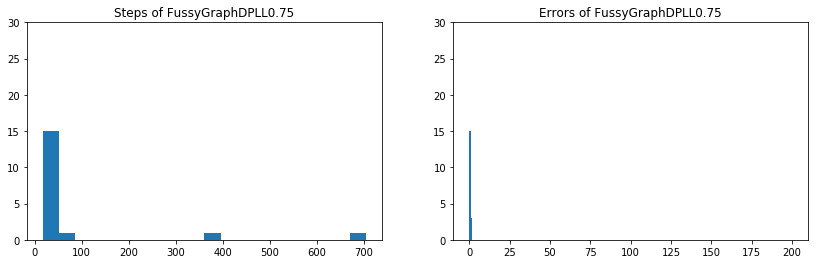

  0%|          | 0/30 [00:00<?, ?it/s]

I (g|~i|q)&(b|d|i|s)&(~h|o|~n|~b)&(m|c|~n|~e)&(s|~l|~r)&(~a|l|~h|r|n|~i)&(e|~r|~c)&(~t|b|~r)&(m|~p|~j|d|~a)&(o|~m|~c)&(j|o|~n|t|~g|~c)&(j|i|p|r)&(~d|~g|o|~m)&(m|n|l)&(s|~l|n|t|~g)&(~i|~n|~j)&(~c|t|f)&(h|~j|~m|~i|a|~e|c|~b|~l|~g|o)&(j|r|~m|~l|~b)&(p|~f|j)&(s|~a|n|o)&(~m|~d|s|a|~t|b)&(b|j|~t|l|n|o|q|~g|~f|~d|~c)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(r|m|s)&(q|~n|~p|i|r|~c)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(i|~b|g)&(~l|~g|~f)&(~g|t|~c|f)&(~t|~j|~s|e)&(a|e|i|~t)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(j|~r|~e|t|~s|p|~n|i)&(m|p|~a)&(f|g|p|~s)&(~g|~l|~p)&(~l|~c|~b)&(e|i|~t|o|s|~l|~d|~c|~b)&(m|~g|~j|r|~l)&(i|~j|f|~d|~a|r)&(~d|~h|~l|b)&(m|~s|l)&(r|~o|l|j|~t)&(~d|m|j|~i)&(h|~p|~o|~n)&(~t|~f|n)&(c|~i|h|~s)&(~j|~q|e)&(~p|~q|b|m|~d|l|s|~o|~e)&(~q|~a|~e|~b|g)&(~e|c|q|p|~s)&(c|g|~l|p|~e|m)&(~j|~i|~l|r|t)&(n|~e|s)&(i|~n|p)&(l|p|e|~o|r)&(~n|t|j)&(~p|~l|c|~i)&(i|o|~p|~q|~n|~e)&(p|~j|b|~n|c|~d|~a)&(~s|d|~i)&(~m|~o|~j|~i|~l)&(~b|~o|i|~s|~q|~h|~f)&(p|~e)&(p|~o|s)&(d|s|e|~n|c)&(~r|g|~e)&(t|c|d)&(c|~n|~o|j)&(t|~e|~o)&(

I (~i)&(i|b)&(i|j)&(~j|~i)&(j)&(j)&(i|~b)&(i)&(b)&(b)&(~b)&(j|~i)&(~j)&(~b)&(~b)
P [[[0.528 0.528]
  [0.144 0.42 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.291 0.265]
  [0.59  0.067]]]
Fussy cut
I (~g|j)&(~j)&(j)&(a|~e)&(~g|e)&(j|~e)&(j)&(e|~j)&(g|~a|~e|~b)&(e)&(b|~a|~e)&(j|e)&(~a)&(~e|a|g)&(a|~b)&(~g)&(b|~e|g)&(~j)&(e|~j)&(~j)&(~b|g)&(~g|~b)
P [[[0.388 0.339]
  [0.578 0.558]
  [0.528 0.528]
  [0.528 0.528]
  [0.319 0.788]
  [0.528 0.528]
  [0.44  0.713]
  [0.528 0.528]
  [0.528 0.528]
  [0.156 0.754]]]
Fussy cut
I (~g|~c)&(~c|o)&(o)&(~c)&(e|~a|g)&(a|~e)&(e|~h|~o)&(~g|e)&(~g|c|~e)&(~o)&(c|e)&(~o|c)&(~e|~a)&(e)&(h|~a)&(~e|a|g)&(~h|o)&(c|e|~g)&(o)&(g|h|~e|~c)&(g|~o|~h|~c)&(~e)&(a|c)&(c|e)&(h|o)&(~h)&(h|~o)&(~e|~c)&(h)&(~h|~o)&(a|g|h|o)
P [[[0.422 0.319]
  [0.528 0.528]
  [0.295 0.401]
  [0.528 0.528]
  [0.298 0.3  ]
  [0.528 0.528]
  [0.399 0.487]
  [0.325 0.3  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  

I (~o|~d|a)&(e|~r|~c)&(~t|~r)&(~c|o)&(~t|q|~h|~f|~e)&(~c|t|f)&(e|~t|~q|~p|r|~a)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(~p|q|~n|r|~c)&(a|~d|~q)&(~t|e)&(~f|~h|o|~d|~a|~r|~n)&(p|f)&(f|r|~d|~a)&(~t|~f|n)&(e|~q)&(c|p|q|~e)&(~p)&(p|~n)&(e|p|~o|r)&(c|~r)&(~p|q|~e)&(c|p|~n|~d|~a)&(c|~o|~h|~e|~d|~a)&(~e|~r)&(t|~e|~o)&(~e|~a)&(d|h|~q|~a)&(~h|~a)&(~c|f)&(r|f|o|~e)&(~f|o)&(~d|f|n)&(p|d)&(q|~c|e)&(n|~e|h)&(h|~e|~c)&(~h|~r|n)&(~c|t|~o)&(~e|t|o)&(~h|~o|~c)&(c|a|r)&(r|~q)&(r|e)&(e|~p|c)&(d|~q|p|t)&(~n|~h|~f)&(n|h|p)&(r)&(t|~q|~r|~c)&(h|~o|~p)&(~p|~f|~e|~c)&(~p|h)&(~o|~n|~h)&(a|d|h|o|~n)
P [[[0.22  0.599]
  [0.528 0.528]
  [0.121 0.427]
  [0.193 0.282]
  [0.15  0.555]
  [0.504 0.175]
  [0.528 0.528]
  [0.146 0.706]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.141 0.453]
  [0.17  0.395]
  [0.565 0.071]
  [0.173 0.352]
  [0.489 0.189]
  [0.528 0.528]
  [0.239 0.231]]]
Fussy cut


  3%|▎         | 1/30 [00:15<07:26, 15.41s/it]

I (o)&(~o)&(o)&(~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (m)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (m)&(a)&(a)&(a)&(~m)&(a|m)&(~a)
P [[[0.727 0.694]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.314 0.252]]]
Fussy cut
I (a)&(m)&(a)&(~m)&(a)&(a|m)&(~a)
P [[[0.727 0.694]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.314 

I (n)&(~k)&(k|~l|~a)&(a|~g|l)&(~g|~c|m)&(~g|r|~a)&(o)&(k|~c|~a)&(~a|g|~n)&(l|a)&(a)&(g|m|~o|~n|~a)&(r|~m|n)&(~c|m)&(c|~a)&(c|l|~r)&(~n|~c|o)&(~m|l|~r)&(g|~o|~m|r)&(l|~n|r|~g|~c)&(~k|a|l|~n|c)&(~o|~r)&(l|~r)&(~c|a|~r)&(~g|~l)&(m)&(a|~l)&(~m|g|~n|~l)&(~k|r|m)&(~o|~m)&(a|~n)&(g|k|~a|~c)&(k)&(a|~c)&(k|~r)&(~m|o)&(~n|~r|~m)&(~o|~k)&(a|c|m|~r)&(a|r|c)&(a|g|m|~l)&(a|~n)&(c|~k|l|g)&(~c|~a|~k)&(m|k|~a)&(~n|~k|~a)
P [[[0.628 0.128]
  [0.528 0.528]
  [0.779 0.217]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.401]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.163 0.601]
  [0.493 0.597]
  [0.528 0.125]
  [0.5   0.26 ]
  [0.146 0.368]
  [0.528 0.528]
  [0.528 0.528]
  [0.117 0.565]]]
Fussy cut
I (n)&(q|~k)&(k|~l|~a)&(a|~g|l)&(~g|r|~a)&(~f)&(k|~c|~a)&(~a|g|~n)&(f|~r)&(q|a|l)&(q|~c)&(c|~a)&(~q|a|r|g)&(k|~l|f)&(l|f)&(~n|~c)&(~n|~a|f)&(~g|~q|c)&(f|k|~l|~c)&(a|f|~l|~g)&(l|~n|r|~g|~c)&(~k|a|l|~n|c)&(~k|r|f)&(l|~r)&(~c|a|~r)&(~g|c)&(~q)&(~l|~g|~f)&(~f)&(a|~l)&(r|~k)&(c|f|g|l)&(a|~n)&(g

 10%|█         | 3/30 [00:31<04:55, 10.93s/it]

I (j)&(p|~j)&(j)&(~j)&(~p|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.395 0.123]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.433 0.433]]]
Fussy cut
I (a)&(a)&(~a)&(~a)
P [[[0.224 0.224]]]
Fussy cut
I (~p|d)&(~d)&(d|~a)&(a|p|~d)&(d)&(~p|~d)
P [[[0.314 0.383]
  [0.528 0.528]
  [0.528 0.528]
  [0.227 0.276]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.28  0.644]]]
Fussy cut
I (e)&(e|~a)&(e)&(a)&(~e)&(~a)&(~a)&(a|~e)
P [[[0.19  0.305]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.305 0.19 ]]]
Fussy cut
I (q|d|~a)&(e)&(q)&(e|~a)&(~d|~q)&(q|~e|d)&(e)&(d|~a|~q)&(a|~d)&(~e)&(d|e)&(a)&(~e|~q)&(~a)&(a|~e)&(a|~e|d)
P [[[0.289 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.526 0.26 ]
  [0.273 0.287]
  [0.528 0.

I (c|~r|p|t|~e)&(~n|~a)&(o|~k|~f|~c)&(a|p|~n|t|~f|~e)&(e|~j|f)&(e|r|~l)&(~p|e|~f|~l)&(i|~e|~j)&(~q|~j|~d|~n)&(i|n|~r|~o)&(~a|q|j|d)&(n|~c|l|~r|e)&(j|k|q)&(~p|l|d)&(f|i|q|p|t)&(~o|~e|~d)&(~f|j|i|o)&(~j|k|~e|~p|~i)&(~p|f)&(r|~e|~l)&(~q|~n|a)&(j|~i|~t)&(~t|q|d|~p)&(c|~o|q|~e)&(f|i|~a|e)&(~d|~q)&(~c|e|~f|t)&(a|c|d|e|j|p|q|r|~i)&(d|i|~t|o|q|~e)&(~p|q)&(~a|~n|p|f)&(f|~l|n)&(a|e|l|o|q)&(c|d|f|j|~o|~n)&(e|~r|p)&(d|~a|~q)&(r|~d|~f|~t|c|i)&(a|p|~d)&(i|l|~k|~f)&(t|r|d)&(k|~j|t|l|i)&(o|~a|t|~j|~c)&(c|~q|r|~k|~d)&(c|f|i|~q|o)&(~j|~i)&(e|k|~o|~n)&(a|i|n|~r|~d)&(~o|a|f)&(i|r)&(~t|~q|~n)&(~d|~q)&(c|n|o|~r)&(d|e)&(~n|~i|~j)&(~q|l|~e|~o)&(k|f|a)&(q|~c|~l)&(i|n|o|r|~c)&(~t|p|~j)&(k|~l|f)&(~o|~l|~i)&(j|~k|~a)&(a|i|~r|p|~k|~f)&(j|~r|d|~p)&(n|~t|~f|o|i|~l)&(~a|f|~c)&(j|o|~r|~f)&(c|~n|~l)&(o|l|t)&(~f|~c|e|q|~r)&(~d|c|~p|~j)&(~l|r|~q)&(c|l|e)&(~o|r|~q|i|~l|j)&(~n|~p|~i)&(a|~e|n)&(j|~t|~q|o|~f)&(~e|~o|~r)&(c|~f|~i)&(~d|~n|k)&(~p|q|~j|~d)&(o|p|t|~k|~i|~d|~c|~a)&(l|~t|~q|~k)&(c|~j|n)&(r|c|~j)&(a|~e|d)&(~r|o|p|~e

 30%|███       | 9/30 [00:48<00:52,  2.50s/it]

I (t)&(p|t)&(~p|t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.095]]]
Fussy cut
I (t)&(p|t)&(~p|t)&(t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.087 0.326]]]
Fussy cut
I (p)&(~p|c)&(~p|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]

I (~s)&(i)&(~i)&(s)&(s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~s)&(i)&(s)&(~i)&(s)&(~i)&(s)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (s|~q)&(~s)&(~q)&(q)&(s)&(~s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.

I (j)&(j)&(~j)&(~j)&(~p)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~j)&(j)&(j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut


 37%|███▋      | 11/30 [01:01<01:19,  4.20s/it]

I (p)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (p)&(g)&(~p)&(g)&(~p|g)&(~g)&(~p|g)&(~p|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.547 0.05 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.06 ]]]
Fussy cut
I (h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~d)&(d)&(h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(p|l)&(~p|l)&(l)&(l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

I (~o|~k)&(k|o)&(r|g)&(l|g)&(~k|~r)&(~g|~r)&(~g|t|~l)&(~t|g)&(k|~t|d)&(k|~l|t)&(~t|o)&(l|~k|t)&(~o|t|g)&(~g|~t)&(~r|o|t|~h|~g)&(g|k|r|t)&(r|o)&(r|o)&(r|~d)&(~o|~t|~d)&(o|g|~k|d)&(~h|~l|~r)&(h|t)&(l|t|~k)&(r|k)&(~h)&(k|t|h)&(t|~k)&(~l|~k)&(~d|l|o)&(l|d)&(~g|k)&(k)&(h|~g|o)&(t|d|~h)&(k|~l|g)&(~h)&(t|~l)&(d|r|~k|~h)&(h|l|~t|~g|~d)&(r|d|t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.56  0.293]
  [0.528 0.528]
  [0.528 0.528]
  [0.586 0.285]
  [0.172 0.66 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.794 0.176]
  [0.765 0.402]
  [0.528 0.528]
  [0.528 0.528]
  [0.521 0.194]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.119]
  [0.528 0.528]
  [0.761 0.171]]]
Fussy cut
I (p|~k)&(l|g)&(k)&(p|l|~k)&(p|k|g)&(k)&(~p|~k)&(~l|~k)&(l)&(~l)&(~g|k)&(p|k)&(k|~l|g)&(~k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.586 0.26 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.298 0.251]
  [0.255 0.256]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0

 40%|████      | 12/30 [01:15<02:04,  6.90s/it]

I (~t)&(t|f|~r)&(t|f)&(~f|t)&(r|~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.559 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.404 0.566]
  [0.528 0.528]
  [0.251 0.332]]]
Fussy cut
I (~t|e)&(~e|~r)&(t|f|~r)&(r|~t)&(~e|f)&(t|e|f)&(r|~e)&(~f|t)&(r|~t|f)&(r|f)&(~e|~t)&(~e|~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.197 0.756]
  [0.491 0.171]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.609 0.269]
  [0.528 0.528]
  [0.278 0.446]]]
Fussy cut
I (~f)&(t|f)&(~f|t)&(~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.211 0.351]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

 43%|████▎     | 13/30 [01:16<01:28,  5.20s/it]

I (~g)&(g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~g)&(~g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (q)&(q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (a)&(g)&(~g)&(~a|g)&(g)&(~g)&(~a)&(a)&(~a)
P [[[0.185 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]]]
Fussy cut
I (q)&(~q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (~d|~a)&(d)&(d|g)&(~g|q)&(~d)&(~d|~a|g)&(a|~m)&(q)&(~d|~q)&(a|~d)&(~d|~q)&(m|d)&(d)&(~m|~a)&(~q)&(~g|a|~q)
P [[[0.221 0.178]
  [0.528 0.528]
  [0.528 0.528]
  [0.332 0.673]
  [0.528 0.528]
  [0.528 0.528]
  [0.569 0.53 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.391 0.763]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.284 0.143]]]
Fussy cut
I (d)&(~m)&(d|g)&(~d)&(~d|~a|g)&(~g|~m)&(a|~d)&(m)&(d)&(~m|~a)
P [[[0.197 0.6  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.318 0.326]
  [0.528 0.528]
  [0.528 0.528]
  [0.458 0.363]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.691 0.558]]]
Fussy cut
I (~o|~d|~a)&(~e)&(~e|d)&(d)&(~e|~d|o)&(~o|~e|~d)&(~d)&(~e)&(~d)&(a|~d)&(o)&(e)&(~o|~e|~d)&(~o|~e)&(~d)&(~o|d)&(d|e)&(~e|d)&(~e)&(~a)&(~o|e)&(a)
P [[[0.708 0.023]
  [0.528 0.528]
  [0.528 0.528]
  [0.063 0.688]
  [0.541 0.125]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.52

 47%|████▋     | 14/30 [01:29<02:01,  7.60s/it]

I (~o|~d)&(d)&(~d)&(o)&(~o)&(o)&(o)&(~d)&(~o|d)&(d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.225 0.225]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.256 0.205]]]
Fussy cut
I (l|~q)&(~l|~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (e|~q)&(k|e|~q)&(~e|~k)&(q)&(e|~q)&(k|~e)&(k|e|q)&(q|e)&(~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.127]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.72  0.174]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.092 0.095]]]
Fussy cut
I (~q)&(~q)&(q)&(q)
P [[[0.528 0.528]


I (o)&(~o)&(~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (o|~q)&(~o)&(o)&(~o)&(q|~o)&(q|o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.218 0.245]
  [0.528 0.528]
  [0.529 0.258]]]
Fussy cut
I (~i)&(i)&(~i)&(i)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~o)&(~r)&(~p)&(~o)&(r)&(~p)&(o)&(~o)&(p|~o)&(p|~o)&(r|o)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.

 50%|█████     | 15/30 [01:42<02:19,  9.32s/it]

I (o|~q)&(~p|~q)&(q)&(~o)&(o)&(p)&(~q)&(~p|~o|~q)&(~o)&(p|~o)&(q|~o)&(q|o)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.337 0.285]
  [0.352 0.267]
  [0.377 0.398]]]
Fussy cut
I (o)&(~o|c)&(~o|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (f|o)&(f)&(o)&(f)&(~o|f)&(~o|f)&(~o)&(f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.566 0.026]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.071 0.298]]]
Fussy cut
I (f)&(~f)&(~f)&(n)&(~n)&(n)&(f)&(n)
P [[[0.528 0.528]
  

I (g)&(~c|~r)&(~g|~n|~r)&(r)&(~n|~r|g)&(~g|c)&(~g)&(~n)&(n)&(~n|g)&(r|~n)&(r|n)&(n|g)&(~r)&(n|~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.353 0.333]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.33  0.268]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.312 0.332]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.251 0.338]]]
Fussy cut
I (~f)&(f)&(~f)&(f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~g|~n|~r)&(r)&(~n|~r|g)&(~g)&(~g)&(~n)&(n)&(~n|g)&(r|~n)&(r|n)&(n|g)&(~r)&(n|~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.217 0.691]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.317 0.313]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.299 0.292]]]
Fussy cut
I (~r|~q)&(r|~q)&(q)&(~q)&(q)&(~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.

 57%|█████▋    | 17/30 [01:53<01:27,  6.76s/it]

I (l|~m|~e)&(l|~e|t|~p)&(i|~d|g)&(~j|o|h|~s|r|c|~k)&(~r|s|~n|~d)&(i|j|~t|l|s|~e)&(d|~c|l|k|m)&(d|~t|c|~r|~h)&(r|~p|~m|a)&(n|~d|~s|i|a|j|m|h|k)&(l|p|~n|~g)&(h|m|~r|p|~o|~k|~j|~d)&(n|e|~i|j)&(~l|g|o|s|i)&(~t|~n|~p)&(~h|l|~m)&(~s|d|g)&(d|e|g|i|~p|~l|t)&(j|~l|p)&(~s|h|~k|o)&(s|~r|~m)&(~i|m|h)&(r|~d|p|~e)&(m|~l|k|i)&(r|~l|~m)&(r|~d|o)&(~a|~d|~o)&(p|~d|o)&(l|p|h|i|o)&(k|~c|i|o|~s|n)&(~m|n|e|~i|~s|~g|~h|j|~r)&(p|r|i|~m|l)&(i|j|n)&(e|d|~g|~t|~s|h)&(~i|~g|~r)&(~t|~g|k)&(~o|~j|~a)&(i|d|a|~l)&(~o|d|p|s)&(~k|o|~h)&(~o|~k|~t|i)&(t|a|~r)&(~d|~o|~c|~n)&(s|~p|r|j|i)&(~k|~a|e)&(a|~o|k)&(g|i|k|m|o|r|s|t|~l)&(r|~a|~l)&(r|~d|~k)&(i|k|~t|m|n|~e)&(k|~c|~t)&(p|m|r)&(s|~a|p|i|~g)&(c|~h|m)&(j|i|o)&(n|a|c)&(l|~a|n|~i|~g|~j)&(t|~h|g)&(l|~r|o|~p)&(~h|~k|~a|n)&(~p|o|~s|~l)&(j|~k|~g)&(~t|o|n|h|~j)&(o|t|~g)&(i|~c|~a|d|o|~l)&(g|l|o|~j)&(o|~e|k)&(~c|~g|r)&(~a|k|l)&(~i|~n|~t|l|e|j)&(l|~n|d|t)&(~n|a|~d|~s)&(~h|r|s)&(e|m|p|~i)&(~i|~e|~d)&(c|i|~p|s|~l|~m|~j)&(~l|s|~e)&(a|t|e|~r)&(~t|~i|l|m|e|j)&(~l|~i|a)&(g|h|~t|~s|~r|~e|

I (i|~d|g)&(h|~s|o|r|~k|~j)&(~r|s|~n|~d)&(d|~t|~r|~h)&(~p|a|r)&(p|~g|~n)&(j|n|~i)&(~t|~n|~p)&(~h)&(~s|d|g)&(~s|h|~k|o)&(s|~r)&(~a|~d|~o)&(p|~d|o)&(h|i|o|p)&(j|~s|n|~r|~i|~h|~g)&(p|i|r)&(i|j|n)&(d|h|~t|~s|~g)&(~i|~g|~r)&(~t|~g|k)&(~o|~j|~a)&(~o|d|p|s)&(g|k|p|t)&(~k|o|~h)&(a|i|k|~t|~g)&(~o|~k|~t|i)&(t|a|~r)&(s|~p|r|j|i)&(~k|~a)&(a|~o|k)&(r|~d|~k)&(n|~o|s|~k|~i)&(~h|p|~j)&(~k|~i)&(~t|~o|r|~k)&(s|~a|p|i|~g)&(i|~n|t|~g)&(j|i|o)&(a|n)&(n|~j|~i|~g|~a)&(t|~h|g)&(~p|~r|o)&(~h|~k|~a|n)&(i|t|~k|~h)&(j|~k|~g)&(~t|o|n|h|~j)&(o|t|~g)&(o|~j|g)&(k|~a)&(j|~t|~n|~i)&(~n|t|d)&(~n|a|~d|~s)&(~h|r|s)&(a|t|~r)&(d|k|~t|s|~h)&(~o|k|h|g)&(d|j|~r|~p|~o|~g|~a)&(d|i|~p|~o)&(d|h|n|r)&(a|j|~s|~r|~p|~n)
P [[[0.237 0.437]
  [0.528 0.528]
  [0.528 0.528]
  [0.644 0.148]
  [0.528 0.528]
  [0.528 0.528]
  [0.483 0.322]
  [0.138 0.774]
  [0.687 0.183]
  [0.585 0.227]
  [0.137 0.574]
  [0.528 0.528]
  [0.528 0.528]
  [0.583 0.256]
  [0.382 0.347]
  [0.509 0.37 ]
  [0.528 0.528]
  [0.269 0.585]
  [0.525 0.412]
  [0.232 0.75

 60%|██████    | 18/30 [02:05<01:41,  8.48s/it]

I (l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.095 0.681]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (r)&(r)&(r)&(~r)&(~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

I (~e)&(e)&(e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~e)&(~e)&(e)&(e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (~e)&(t)&(~e|t)&(e)&(~t)&(~e)&(e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.336 0.147]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.226 0.17 ]]]
Fussy cut
I (~g|~t|n)&(~l|~t)&(l|t|g)&(~t)&(n)&(t)&(~t|n|g)&(~n|t)&(n)&(~t)&(t)&(~l|n)&(~n|l)&(~n|~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.381]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.281 0.51 ]
  [0.528 0.528]
  [0.569 0.243]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.52

 70%|███████   | 21/30 [02:20<00:46,  5.20s/it]

I (i)&(~g)&(g)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~c)&(c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.005 0.751]]]
Fussy cut
I (c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(~c|~j)&(c)&(~c)&(j|c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.249 0.249]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (~n)&(~n)&(~n)&(n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~n)&(~n|~c)&(~n)&(c)&(n)&(~c|n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.692 0.198]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.283 0.283]]]
Fussy cut
I (~r)&(~i)&(r)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~r)&(r)&(f)&(r|~k)&(~r)&(k)&(~f|r)&(~f)&(~f|~k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.

 83%|████████▎ | 25/30 [02:34<00:14,  2.93s/it]

I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]


 90%|█████████ | 27/30 [02:40<00:07,  2.64s/it]

I (~m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.005 0.751]]]
Fussy cut
I (~o)&(~o|~c)&(~o)&(c|~o)&(o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.326 0.087]]]
Fussy cut
I (m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (i)&(~e|m)&(i)&(~m)&(~m|i)&(i)&(e)&(~i)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.293 0.128]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.53  0.4  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.5

I (~m)&(m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (m)&(~m)&(m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (m)&(~m)&(~m)&(~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut


 93%|█████████▎| 28/30 [02:53<00:12,  6.01s/it]

I (l)&(~l)&(l)&(b|l)&(b|~c)&(~g|~b)&(~g)&(l|g)&(~l)&(l)&(b)&(~c)&(c|g)&(~l|~b)&(c|l)&(~l|b|~c)&(l)&(b|c|l)&(b)&(b)&(~b)&(~g|c)
P [[[0.528 0.528]
  [0.306 0.741]
  [0.473 0.587]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.287 0.552]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.368 0.743]]]
Fussy cut
I (j)&(~j)&(j)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (j)&(~j)&(j)&(j)&(j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.178 0.166]]]
Fussy cut
I (f)&(~f)&(f)&(~f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.112 0.628]]]
Fussy cut
I (~c|f)&(~j)&(~f)&(j|c)&(f|~j)&(~l|f)&(j|l)&(j)&(~f)&(~f|c)&(j|f)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.58  0.196]
  [0.528 0.528]
 

I (f)&(~f)&(f)&(~f)&(f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (~e)&(f|~j)&(~e|~j)&(~f)&(j|t)&(j|~t)&(~t|~j)&(f|~j)&(~f|e)&(~e|f)&(~j)&(f)&(j|~t)&(j)&(~f|~t|~e)&(e|f)&(e)&(~t|f|j)&(t|~j)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.194 0.474]
  [0.299 0.244]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.177 0.707]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.579 0.696]]]
Fussy cut
I (f|~j)&(~e|~j)&(~f)&(j|t)&(j|~t)&(~e|~t|m)&(~t|~j)&(m|e)&(f|~j)&(~f|e|~m)&(~e|f)&(~t|f|o)&(~m|~j)&(m)&(j|~m|~t)&(j)&(~f|~t|~e)&(~m|e|f)&(t|o)&(~t|f|j)&(m|o)&(t|~j)&(j)&(~o|f)&(~f|t)&(~f|t|o)&(~f|~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.108 0.727]
  [0.114 0.305]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.173 0.405]
  [0.528 0.528]
  [0.528 0.528]
  [

 97%|█████████▋| 29/30 [03:07<00:08,  8.28s/it]

I (~n|~t)&(~e)&(~t|e)&(~e|~t)&(e)&(t|n)&(~e|~t)&(e|~t)&(~e|t|n)&(~n|t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.242 0.286]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.311 0.34 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.239 0.507]]]
Fussy cut


100%|██████████| 30/30 [03:08<00:00,  6.00s/it]


Within 1e3 steps solved 18 problems out of 30
#Sats: 18; avg step: 79.50; stdev step: 168.41; avg error: 0.17; stdev error: 0.37


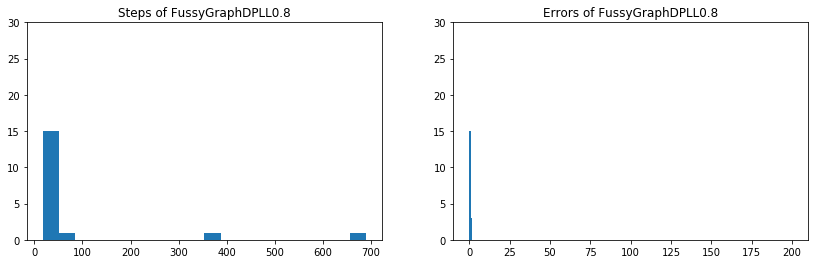

  0%|          | 0/30 [00:00<?, ?it/s]

I (g|~i|q)&(b|d|i|s)&(~h|o|~n|~b)&(m|c|~n|~e)&(s|~l|~r)&(~a|l|~h|r|n|~i)&(e|~r|~c)&(~t|b|~r)&(m|~p|~j|d|~a)&(o|~m|~c)&(j|o|~n|t|~g|~c)&(j|i|p|r)&(~d|~g|o|~m)&(m|n|l)&(s|~l|n|t|~g)&(~i|~n|~j)&(~c|t|f)&(h|~j|~m|~i|a|~e|c|~b|~l|~g|o)&(j|r|~m|~l|~b)&(p|~f|j)&(s|~a|n|o)&(~m|~d|s|a|~t|b)&(b|j|~t|l|n|o|q|~g|~f|~d|~c)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(r|m|s)&(q|~n|~p|i|r|~c)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(i|~b|g)&(~l|~g|~f)&(~g|t|~c|f)&(~t|~j|~s|e)&(a|e|i|~t)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(j|~r|~e|t|~s|p|~n|i)&(m|p|~a)&(f|g|p|~s)&(~g|~l|~p)&(~l|~c|~b)&(e|i|~t|o|s|~l|~d|~c|~b)&(m|~g|~j|r|~l)&(i|~j|f|~d|~a|r)&(~d|~h|~l|b)&(m|~s|l)&(r|~o|l|j|~t)&(~d|m|j|~i)&(h|~p|~o|~n)&(~t|~f|n)&(c|~i|h|~s)&(~j|~q|e)&(~p|~q|b|m|~d|l|s|~o|~e)&(~q|~a|~e|~b|g)&(~e|c|q|p|~s)&(c|g|~l|p|~e|m)&(~j|~i|~l|r|t)&(n|~e|s)&(i|~n|p)&(l|p|e|~o|r)&(~n|t|j)&(~p|~l|c|~i)&(i|o|~p|~q|~n|~e)&(p|~j|b|~n|c|~d|~a)&(~s|d|~i)&(~m|~o|~j|~i|~l)&(~b|~o|i|~s|~q|~h|~f)&(p|~e)&(p|~o|s)&(d|s|e|~n|c)&(~r|g|~e)&(t|c|d)&(c|~n|~o|j)&(t|~e|~o)&(

I (q|g)&(~h|r)&(~c|~r)&(~g|j|~c)&(~c|o)&(j|o)&(~c|f)&(j|~c|~q)&(o)&(p|q)&(~h|~o)&(~g)&(~g|~c|f)&(~j|~q)&(~p|~j)&(p|~o|r)&(c|~r)&(j)&(h|~q)&(~h|~j)&(f|j|~o|~c)&(o|j|~h)&(~g|c)&(~f|o)&(o|p|~q|~g)&(q|~c)&(c|f|h|o|p|r|~g)&(~o|~c)&(g|~o|~h|~c)&(r|~j|~q)&(h|~g)&(~h|~g)&(r|~j)&(~p|c)&(h|j|o)&(h|~c|~q)&(p|~q)&(h|p)&(r|~j)&(~c|~r|~q)&(h|~o|~p)&(~p|h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.162 0.85 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.457 0.328]
  [0.164 0.431]
  [0.144 0.832]
  [0.528 0.528]
  [0.644 0.23 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.313 0.235]
  [0.568 0.516]
  [0.836 0.061]
  [0.355 0.271]]]
Fussy cut
I (q|g)&(~h|r|~a)&(e|~r|~c)&(m|~p|~j|~a)&(~g|j|~c)&(o|~m|~c)&(m)&(f|q|~o|~g)&(j|o)&(~c|f)&(j|~c|~q)&(~a|o)&(p|q)&(~e|a|~f)&(e|~h|~o)&(r|m)&(~g|e|~m)&(h|~e|j|p)&(c|m|r|~a)&(~g|~c|f)&(~p|~g|c|~e)&(m|p|~a)&(~j|~q|e)&(g|~q|~a|~e)&(~p|~j)&(~e)&(e|p|~o|r)&(c|~r)&(~p|q|~e)&(~r|g|~e)&(~o|~e)&(j|e)&(h|~a|~q)&(~h|~a|~j)&(j|f|~o|~m|~c)&(r|f|o|~e)&(o|j|~h)&(c|e|~g

I (~r)&(j)&(~m)&(j)&(j)&(~m)&(~j)&(m)&(~j)&(~j)&(j)&(m)&(m)&(r|~j)&(r|~m|~j)&(r|m)&(r|~j)&(~m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.201 0.241]
  [0.528 0.528]
  [0.528 0.528]
  [0.243 0.236]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.371 0.355]]]
Fussy cut
I (~o|~d|a)&(m|c|~n|~e)&(e|~r|~c)&(~t|b|~r)&(j)&(m|~p|~j|d|~a)&(o|~m|~c)&(p|j|r)&(~m|~d|o)&(m|n)&(q|~o|~b)&(j|o)&(t|~c)&(j|~c|~q)&(q|t|p)&(~p|q|~n|r|~c)&(~m|e)&(p|j|~e)&(c|m|t|r|~a)&(a|~d|~q)&(t|~c)&(e|~t|~j)&(~p|c|~e)&(j|~r|p|~n|t|~e)&(m|p|~a)&(r|~j|~d|~a)&(m)&(j|~t|~o|r)&(~j|~q|e)&(c|p|q|~e)&(~p|~j)&(p|~n)&(e|p|~o|r)&(c|~r)&(~n|t|j)&(~p|q|~e)&(p|~j|b|~n|c|~d|~a)&(c|~n|~o|j)&(t|~e|~o)&(~m|b|~a|~e)&(j|e)&(d|~a|~q)&(~c)&(j|~o|~m|~c)&(r|~e|o)&(c|e)&(e|j|~r|~n|~d)&(~t|~q|p|~c)&(~d|n)&(~c|~n|~t|m)&(p|~m|d)&(p|~q|o)&(e|q|~m|~c)&(m|a)&(b|c|o|p|r)&(~e|n)&(~c|t|~o)&(~e|t|o)&(j|~r|n)&(b|e|~t|n|r)&(a|~d|j)

  3%|▎         | 1/30 [00:08<03:58,  8.24s/it]

I (~o|~d|a)&(q|g)&(~h|o|~n|~b)&(m|c|~n|~e)&(n|r|~h|~a)&(e|~r|~c)&(~t|b|~r)&(j)&(m|~p|~j|d|~a)&(o|~m|~c)&(~d|~g|o|~m)&(m|n)&(f|q|~o|~g|~b)&(~n|~j)&(j|o)&(~t|q|~h|~f|~e)&(~c|t|f)&(j|~c|~q)&(e|g|~t|~q|~p|r|~a)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(a|~d|~q)&(~g|t|~c|f)&(e|~t|~j)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(m|p|~a)&(p|f|g)&(m)&(j|~t|~o|r)&(j|~d|m)&(~t|~f|n)&(h|c)&(~j|~q|e)&(~q|~a|~e|~b|g)&(c|p|q|~e)&(~p|~j)&(e|p|~o|r)&(c|~r)&(~n|t|j)&(~p|q|~e)&(p|~j|b|~n|c|~d|~a)&(~d)&(d)&(c|~o|~h|~e|~d|~a)&(~r|g|~e)&(c|~n|~o|j)&(t|~e|~o)&(~m|b|~a|~e)&(j|e)&(d|h|~q|~a)&(~h|~a|~j)&(j|f|~o|~m|~c)&(r|f|o|~e)&(a|g|~t|~e)&(o|j|~h)&(c|e|~g)&(b|~f|o)&(~r|q|~b|~h)&(a|~b)&(~t|~q|p|~g|~c)&(~d|f|n)&(~c|~n|~t|m)&(p|~m|d)&(o|p|~q|~g)&(e|q|~m|~c)&(a|~r|~q|~m)&(b|p|c|r|h|o|f|~g)&(n|~e|h)&(b|g|h|~e|~c)&(~h|~r|n)&(~c|t|~o)&(b|~f|m)&(~g|n|r|~t|h|e|b)&(c|~n|h|g|p|~b)&(g|~o|~h|~c)&(a|~d|j)&(a|~m|c|r)&(r|~j|~q)&(d|r|~g|~e)&(~t|~r|~p|~o|~m|~j)&(h|~g|t)&(e|r|~m|~j)&(e|~p|c)&(h|j|o)&(h|~n|~t)&(b|d|

I (~g)&(g)&(p)&(p|~g)&(p)&(~g)&(~g)&(~p)&(~g)&(p)&(g)&(p)&(~g)&(~p|~g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.016 0.449]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.335 0.147]]]
Fussy cut
I (~p)&(~g|r)&(g)&(p|~g)&(p)&(~g)&(r|~m|g)&(s|g)&(~r)&(~g|~s)&(~p|m)&(~m|g)&(~g)&(p|s)&(p)&(~m|g)&(r)&(p)&(~m)&(r)&(~p|~g)&(~r)&(s|~r|~m)&(m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.084 0.154]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.436 0.821]
  [0.528 0.528]
  [0.528 0.528]
  [0.612 0.1  ]
  [0.528 0.528]
  [0.715 0.207]
  [0.269 0.53 ]]]
Fussy cut
I (k|~a)&(~g|m)&(~g|b|m)&(~a|g)&(a)&(b|~k)&(g)&(~b)&(a)&(m)&(~m|g)&(~g|b|k)&(~g)&(a)&(~m|g)&(~g|b)&(b|g)&(~m)&(k|~a|g)&(a|b)&(a)&(~g)&(k)&(~m)&(b)&(a|m|g)&(a)&(~k|~a)&(m|k|~a)&(~k|~a)
P [[[0.791 0.13

I (n)&(k|~l|~a)&(a|~g|l)&(~m|f)&(~f|o)&(~f|~q)&(~g|~n|m)&(k|~c|~a)&(~f|n)&(~a|g|~n)&(q|a|l)&(q|~f|~n|m|~o|~a|g)&(q|m|~c)&(c|~a)&(k|~l|f)&(l|f)&(k|~l)&(~n|~a|f)&(~g|~q|c)&(f|k|~l|~c)&(~k|a|l|~n|c)&(l)&(a|~c)&(~g|c)&(m|~q)&(~f|~g|k)&(~l|~g|~f)&(~o|k|f)&(a|~l)&(~m|g|~n|~l)&(~n|~l|g)&(~m|l|o)&(f|l|m|c|g)&(a|~n)&(g|k|~a|~c)&(a|~q)&(a|~n)&(q|k)&(a|~c)&(o|~m|~f)&(~o|q|~k)&(a|c|m)&(~m|l|n)&(a|g|m|~l)&(a|c|q)&(a|~n)&(c|~k|l|g)&(~n)&(~c|~a|~k)&(~k|f|~l)&(k|l|~m)
P [[[0.699 0.191]
  [0.528 0.528]
  [0.668 0.25 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.402]
  [0.289 0.743]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.823 0.53 ]
  [0.726 0.379]
  [0.501 0.413]
  [0.613 0.559]
  [0.777 0.305]
  [0.528 0.528]
  [0.302 0.702]]]
Fussy cut
I (n)&(a|~g)&(~g|~a)&(~g|~n|m)&(~a)&(n)&(~a|g|~n)&(a)&(g|m|~n|~a)&(m)&(~g)&(~m|g)&(~g)&(~n)&(a|~n)&(a|~n)&(~a|g)&(g)&(a|~n)&(a)&(~m|n)&(a|~n)&(~n|~a)&(~n)
P [[[0.744 0.063]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0

 10%|█         | 3/30 [00:25<03:25,  7.63s/it]

I (m|~r|p|c|~e|t)&(f|q|~t|~h)&(~n|h|~a)&(~k|h|~c|~f|o)&(d|~l|~h|t|b)&(n|~g|h|f|s)&(c|~m|j|d|~n)&(m|a|~e|p|~b|~n|t|~f)&(e|~j|f)&(~r|m|~s)&(m|~l|e|r)&(q|~m|~l|~h)&(~p|e|~f|~l)&(~e|~b|i|~j)&(~e|~c|~j|r|~i|~l|~h)&(~q|~j|~d|~n)&(~c|~s|n|o|~j|~q|~l|~k|~d|i|p|e|a|~t|b|g|~r|~h|~f|~m)&(i|n|~r|~o)&(~a|q|j|d)&(~h|j|~e|~k)&(~o|~g|p|~d|~c|~b|~j)&(m|p|c|~s)&(n|~c|l|~r|e)&(j|k|q)&(g|l|~p|d)&(f|i|q|p|t)&(~d|~o|~e|~b)&(~f|j|i|o)&(~j|k|~e|~p|~i)&(~m|~s|~k|p|~h)&(s|f|~p)&(r|~e|~l)&(~q|~n|a)&(j|~i|~t)&(~t|q|d|~p)&(s|~o|q|~e|c)&(f|i|~a|e)&(~f|~g|~r|h|i|~s|~m|~c|~t)&(s|~q|~d)&(~c|e|~f|t)&(r|~k|~n|~e|~f|l|~h)&(r|q|a|g|d|~i|e|c|j|p)&(m|~t|q|o|~e|s|i|d)&(m|q|~b|s|~p)&(f|a|n|i|q|~m|~s)&(~a|~n|p|f)&(~l|~h|i|~s|~k|~d)&(~n|~f|~k|~p|a|~m|~h|~i|l|g|e)&(f|~l|n)&(a|o|l|q|~b|e)&(c|f|~n|~o|d|j|s)&(s|e|~m)&(e|~r|p)&(~m|f|i|~o|t)&(~a|d|~q|h)&(~a|~s|~t|~m)&(r|~d|~f|~t|c|i)&(a|p|~d)&(~e|a|q|~s|k)&(i|~f|~k|l|h)&(t|r|d)&(k|~j|t|l|i)&(t|m|s|~g)&(o|~a|t|~j|~c)&(~h|~o|a)&(i|~b|s|~g|~n|e|~d|~k|~h|f|~m)&(m|~k|~d|c|r|~q)&(t|s|~b|~g

 17%|█▋        | 5/30 [00:25<02:16,  5.45s/it]

I (i|l|b|~d|a|j)&(d|~c|k|~f|l|~e|g|h)&(r|~s|g|~c|b)&(h|~l|c|~g|k|s)&(a|l|e)&(~d|~r|f|~n|~o|p)&(~p|s|~c|~l|~f|~a|h)&(~t|~f|~s)&(~r|a|t|~g|i|~f|e)&(j|f|~e|h|i)&(~r|d|k|~b|g)&(o|~e|~q|~a|~r|~g|~m|~t|n|k|~f)&(m|k|q)&(e|~k|~s|n|g)&(~f|~j|t|p)&(~l|~f|j|p)&(j|s|~d|l|~i)&(h|~e|q|r)&(o|m|~t|~r|~q|a|f|i|p|n|~l|~e|h)&(~r|b|o|n|~q)&(c|~e|~b|~q|o|~m|~a|~g|~p)&(~i|~t|~p|k|~h|f|n|g|~o)&(~q|m|o|~n)&(d|~a|~i|g|s)&(~d|t|~b|o|~s|~g|n|a|m|j)&(~i|~o|~m|r)&(r|~i|~j|~n|d)&(~k|~m|~g|~e|c)&(~r|k|~e)&(~i|~o|~f)&(k|~p|~s|o)&(n|~h|b|~t|j|~r|~d)&(b|o|r)&(d|~c|~s)&(k|n|~b|~g)&(~e|~b|k|~o|j)&(a|m|b|e)&(l|~q|o|f)&(l|~q|~j|~p|g|b)&(f|~k|r)&(h|~b|~s)&(~p|~o|b)&(m|~g|~j|l|e|h)&(~j|h|t|o)&(l|s|g|f)&(~q|~b|p|~h)&(~k|a|n|~i|o)&(~f|~b|~n|h)&(t|l|f|o)&(~i|~f|e|g)&(~o|j|m)&(t|~g|k)&(a|m|~k|~h|f)&(c|~j|~f)&(k|f|t|p)&(r|~e|p)&(~j|a|~d|q)&(~g|~i|~a|~l|~b)&(~l|~e|a)&(~n|c|~r|~a|~f)&(~l|~r|~h|k)&(~g|~e|o|s)&(o|m|b|~i|~r|s|~n|~f|g|~l|~t)&(~s|g|f|~o)&(j|~f|~m|i)&(~n|~p|m|~r|~d)&(r|m|o)&(i|~r|~s)&(~b|p|c)&(k|l|~j|h|i)&(~d|~p|~f)&(~r|

 30%|███       | 9/30 [00:27<00:47,  2.24s/it]

I (t)&(p|t)&(~p|t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.681 0.095]]]
Fussy cut
I (t)&(p|t)&(~p|t)&(t)&(~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.087 0.326]]]
Fussy cut
I (p)&(~p|c)&(~p|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]

I (~s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~s)&(i)&(~i)&(s)&(s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~s)&(i)&(s)&(~i)&(s)&(~i)&(s)&(i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528

I (j)&(~n|~j)&(n)&(~j|n)&(n|~j)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.733 0.428]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.588 0.678]]]
Fussy cut
I (j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (j)&(j)&(~j)&(~j)&(~p)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~j)&(j)&(j)&(~j)
P [[[0.528 0.528]
  [0.528 0.528

 33%|███▎      | 10/30 [00:43<02:03,  6.16s/it]

I (~n)&(n)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~n)&(~n)&(n)&(n)&(n)&(n)&(~n)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.82  0.843]]]
Fussy cut


 37%|███▋      | 11/30 [00:43<01:25,  4.52s/it]

I (p)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (p)&(g)&(~p)&(g)&(~p|g)&(~g)&(~p|g)&(~p|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.547 0.05 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.06 ]]]
Fussy cut
I (h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~d)&(d)&(h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(p|l)&(~p|l)&(l)&(l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

I (~k)&(k|d)&(~k)&(~d)&(~d)&(k)&(d)&(k)&(k)&(~d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.161 0.723]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.059 0.267]]]
Fussy cut
I (k)&(~k)&(k)&(k)&(~k)&(~k)&(k)&(k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.82  0.843]]]
Fussy cut
I (k)&(l)&(~k)&(k|~l)&(l|~k)&(l|~k)&(d|~k)&(~k|l)&(k)&(~k)&(~l|~k)&(~d|l)&(l|d)&(k)&(k|~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.633 0.231]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.219 0.278]
  [0.34  0.238]]]
Fussy cut
I (k)&(l)&(~k)&(k|~l)&(l|~k)&(l|~k)&(~l)&(~k|l)&(~k)&(~l|~k)&(l)&(~l)&(k)&(k|~l)&(k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

 40%|████      | 12/30 [00:58<02:16,  7.57s/it]

I (t|~l)&(~t)&(t|l)&(l)&(l|t)&(l)&(~l)&(t)&(t|~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.406 0.191]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.499 0.178]]]
Fussy cut
I (~t)&(t|f|~r)&(t|f)&(~f|t)&(r|~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.559 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.404 0.566]
  [0.528 0.528]
  [0.251 0.332]]]
Fussy cut
I (~t|e)&(~e|~r)&(t|f|~r)&(r|~t)&(~e|f)&(t|e|f)&(r|~e)&(~f|t)&(r|~t|f)&(r|f)&(~e|~t)&(~e|~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.197 0.756]
  [0.491 0.171]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.

 43%|████▎     | 13/30 [00:59<01:37,  5.73s/it]

I (~g)&(g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~g)&(~g)&(g)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (q)&(q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (a)&(g)&(~g)&(~a|g)&(g)&(~g)&(~a)&(a)&(~a)
P [[[0.185 0.294]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.294 0.185]]]
Fussy cut
I (q)&(~q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (~e)&(e)&(~m)&(e)&(m)&(~e)&(~e)&(e|m)&(~m)&(~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.106 0.46 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.193 0.281]]]
Fussy cut
I (~e)&(~e|d)&(q)&(~d|e)&(~q)&(e)&(~m|~d)&(q)&(e|~q)&(~d|~q)&(m)&(~e|~q)&(~e|~d)&(e|m)&(m|d)&(d|e)&(~e|d)&(~m)&(e|~q)&(q)&(~e)&(~m|~d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.298 0.395]
  [0.273 0.301]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.253 0.245]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.254 0.325]]]
Fussy cut
I (a|d|r|~l|~c|~b)&(~g|~c|~e)&(a)&(~b|g)&(a|e|l)&(d|~r|~l)&(b|c|~m|q)&(c|~q|~e|~d)&(a|~b|d|m)&(d|g)&(b|~r|q|~m|~g|~e|~a)&(~g|~c|q)&(~d|e|~r)&(a|e|~m|~c)&(c|l|~e|~a)&(c|q|~e)&(g|l|~r|~c|~a)&(~m)&(~m|~d|~b)&(~m|~b|g)&(c|~e|l)&(q|~l)&(e|~q)&(e|~q)&(r|~d|g)&(~m|l)&(m)&(c|l|q|~m|~g)&(~l|g)&(r|~m)&(a|b|~d)&(a|r|

 47%|████▋     | 14/30 [01:13<02:09,  8.12s/it]

I (l|~q)&(~l|~q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (e|~q)&(k|e|~q)&(~e|~k)&(q)&(e|~q)&(k|~e)&(k|e|q)&(q|e)&(~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.215 0.127]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.72  0.174]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.092 0.095]]]
Fussy cut
I (~q)&(~q)&(q)&(q)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l|e|~q)&(l|e|~q)&(~l|~q)&(~e)&(q|e)

I (~o)&(~k)&(r|~k)&(~p|l|o)&(o)&(~o|~l)&(k|~r|p|~o|~l)&(k)&(p|~o)&(p|~o|l)&(p|~o)&(~l|~o)&(r|o)&(~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.027 0.798]
  [0.844 0.313]
  [0.528 0.528]
  [0.528 0.528]
  [0.584 0.308]
  [0.577 0.565]
  [0.528 0.528]
  [0.652 0.051]]]
Fussy cut
I (l)&(k|l)&(~l)&(l|~k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]
  [0.681 0.095]]]
Fussy cut
I (~i)&(r|~k)&(l|~r|~q)&(k|l|~q)&(i)&(r|l)&(q)&(~l)&(r|k|~i)&(i|~l|~q)&(~l)&(i|~k)&(i|k|q)&(q|~l)&(l|~k)&(r|~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.655 0.792]
  [0.528 0.528]
  [0.117 0.619]
  [0.222 0.435]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.52

I (o|~q)&(~p|~q)&(q)&(~o)&(o)&(p)&(~q)&(~p|~o|~q)&(~o)&(p|~o)&(q|~o)&(q|o)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.337 0.285]
  [0.352 0.267]
  [0.377 0.398]]]
Fussy cut


 50%|█████     | 15/30 [01:26<02:21,  9.46s/it]

I (o)&(~o|c)&(~o|~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.315 0.315]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.182 0.238]]]
Fussy cut
I (f|o)&(f)&(o)&(f)&(~o|f)&(~o|f)&(~o)&(f)&(~f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.566 0.026]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.071 0.298]]]
Fussy cut
I (f)&(~f)&(~f)&(n)&(~n)&(n)&(f)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (f)&(q|~f)&(n)&(~q)&(~f|~n|~q)&(n|~q)&(f|~q)&(f)&(~n)&(f)&(n)&(~f)&(q|f)&(q|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (r)&(~n|~r)&(r|~n)&(p|~r)&(r|n)&(~p|~r)&(n|~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.325 0.325]
  [0.528 0.528]
  [0.331 0.331]
  [0.528 0.528]
  [0.243 0.275]]]
Fussy cut
I (f|g)&(c|f)&(~f|g)&(~c|~q)&(~g|~n|~f)&(~n|g)&(~g|c|~q)&(~g|~q)&(~g|q)&(~f|~n|~q)&(~g|f|n)&(n|~q)&(q)&(n|g)&(q|f)&(~f|n)&(q|~c|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.4   0.324]
  [0.528 0.528]
  [0.528 0.528]
  [0.369 0.307]
  [0.343 0.338]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.58  0.235]
  [0.528 0.528]
  [0.528 0.528]
  [0.349 0.255]]]
Fussy cut
I (f|g)&(~f|g)&(q|~f)&(~q)&(~g|~q)&(~g|~q)&(~g|q)&(~f|~n|~q)&(~g|f|n)&(n|~q)&(~n)&(n)&(q)&(n|g)&(q|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.502 0.445]
  [0.843 0.681]
  [0.528 0.528]


 57%|█████▋    | 17/30 [01:35<01:26,  6.62s/it]

I (l|~m|~e)&(l|~e|t|~p)&(i|~d|g)&(~j|o|h|~s|r|c|~k)&(~r|s|~n|~d)&(i|j|~t|l|s|~e)&(d|~c|l|k|m)&(d|~t|c|~r|~h)&(r|~p|~m|a)&(n|~d|~s|i|a|j|m|h|k)&(l|p|~n|~g)&(h|m|~r|p|~o|~k|~j|~d)&(n|e|~i|j)&(~l|g|o|s|i)&(~t|~n|~p)&(~h|l|~m)&(~s|d|g)&(d|e|g|i|~p|~l|t)&(j|~l|p)&(~s|h|~k|o)&(s|~r|~m)&(~i|m|h)&(r|~d|p|~e)&(m|~l|k|i)&(r|~l|~m)&(r|~d|o)&(~a|~d|~o)&(p|~d|o)&(l|p|h|i|o)&(k|~c|i|o|~s|n)&(~m|n|e|~i|~s|~g|~h|j|~r)&(p|r|i|~m|l)&(i|j|n)&(e|d|~g|~t|~s|h)&(~i|~g|~r)&(~t|~g|k)&(~o|~j|~a)&(i|d|a|~l)&(~o|d|p|s)&(~k|o|~h)&(~o|~k|~t|i)&(t|a|~r)&(~d|~o|~c|~n)&(s|~p|r|j|i)&(~k|~a|e)&(a|~o|k)&(g|i|k|m|o|r|s|t|~l)&(r|~a|~l)&(r|~d|~k)&(i|k|~t|m|n|~e)&(k|~c|~t)&(p|m|r)&(s|~a|p|i|~g)&(c|~h|m)&(j|i|o)&(n|a|c)&(l|~a|n|~i|~g|~j)&(t|~h|g)&(l|~r|o|~p)&(~h|~k|~a|n)&(~p|o|~s|~l)&(j|~k|~g)&(~t|o|n|h|~j)&(o|t|~g)&(i|~c|~a|d|o|~l)&(g|l|o|~j)&(o|~e|k)&(~c|~g|r)&(~a|k|l)&(~i|~n|~t|l|e|j)&(l|~n|d|t)&(~n|a|~d|~s)&(~h|r|s)&(e|m|p|~i)&(~i|~e|~d)&(c|i|~p|s|~l|~m|~j)&(~l|s|~e)&(a|t|e|~r)&(~t|~i|l|m|e|j)&(~l|~i|a)&(g|h|~t|~s|~r|~e|

I (a|~m)&(m)&(~m)&(~a)&(a)&(~a)&(m)&(a)
P [[[0.323 0.166]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.303 0.195]]]
Fussy cut
I (a|~m)&(m)&(~m)&(~a)&(a)&(~a)&(m)&(a)
P [[[0.323 0.166]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.303 0.195]]]
Fussy cut
I (a|~m)&(m)&(~m)&(~a)&(~a)&(a)&(~a)&(m)&(a)
P [[[0.227 0.25 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.256 0.194]]]
Fussy cut
I (i|~d|g)&(h|~s|o|r|~k|~j)&(~r|s|~n|~d)&(d|~t|~r|~h)&(~p|a|r)&(p|~g|~n)&(j|n|~i)&(~t|~n|~p)&(~h)&(~s|d|g)&(~s|h|~k|o)&(s|~r)&(~a|~d|~o)&(p|~d|o)&(h|i|o|p)&(j|~s|n|~r|~i|~h|~g)&(p|i|r)&(i|j|n)&(d|h|~t|~s|~g)&(

 60%|██████    | 18/30 [01:49<01:46,  8.86s/it]

I (l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.095 0.681]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.2   0.2  ]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (~b)&(l|~b)&(~b)&(b)&(~l|~b)
P [[[0.528 0.528]
  [0.326 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.415 0.415]]]
Fussy cut
I (r)&(r)&(r)&(~r)&(~r)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

I (~l)&(~n)&(l)&(n)&(l)&(~l|n)&(~n)&(~n|l)&(~n|~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.248 0.242]
  [0.528 0.528]
  [0.079 0.546]]]
Fussy cut
I (~l)&(~n)&(l)&(n)&(l)&(n)&(~l|n)&(~n)&(~n|l)&(~n|~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.451 0.135]
  [0.528 0.528]
  [0.215 0.355]]]
Fussy cut
I (~e)&(~e|t)&(e)&(e)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.218 0.047]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.833 0.211]]]
Fussy cut
I (~e)&(t)&(~e|t)&(e)&(~t)&(~e)&(e)&(e)
P [[[0.528

 70%|███████   | 21/30 [02:05<00:49,  5.55s/it]

I (i)&(~g)&(g)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~c)&(c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.628 0.112]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.005 0.751]]]
Fussy cut
I (c)&(c)&(~c)&(c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (c)&(~c)&(c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (~c)&(c)&(~c|~j)&(c)&(~c)&(j|c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.249 0.249]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (~d)&(d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~n|~c)&(c)&(n)&(~c|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.07  0.782]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.232 0.195]]]
Fussy cut
I (~n|~i)&(i)&(~n)&(n)&(n|~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.214 0.296]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.226 0.226]]]
Fussy cut
I (~n|~i)&(i)&(~n)&(~n)&(n)&(n)&(n|~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.692 0.198]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.283 0.283]]]
Fussy cut
I (~n|~c)&(~n)&(c)&(n)&(~c|n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.214 0.296]
  [0.528 0.528]
  [0.52

 73%|███████▎  | 22/30 [02:18<01:01,  7.69s/it]

I (~m|~r)&(n|~r)&(~c|~n|r)&(~n)&(c)&(~r)&(r)&(~k|m|c|~r)&(~m|~c)&(k|n|~r)&(n)&(~c|n)&(m|~r)&(~c|~k|~r)&(k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.238 0.102]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.27  0.201]
  [0.528 0.528]
  [0.208 0.441]
  [0.173 0.119]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.036 0.764]]]
Fussy cut


 83%|████████▎ | 25/30 [02:20<00:15,  3.03s/it]

I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.224 0.224]]]
Fussy cut
I (l)&(l)&(~l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]


 87%|████████▋ | 26/30 [02:24<00:14,  3.52s/it]

I (p|s|~l)&(d|j|~r|~l|~t|b)&(~e|~r|~f|~j)&(~o|b|~a|~r)&(~p|~b|n)&(k|q|~n|s|~f|g|~j|~i|p|m)&(m|a|t|p)&(l|g|h)&(~n|g|~d|c)&(e|s|~n|j)&(~h|q|a|~m|t|~d|~n)&(~i|~b|~s|~k|h)&(o|~c|~f|t|e|~q|k|~m|i|~r|n)&(p|n|~r|e)&(h|c|~l)&(c|~r|t)&(~f|~g|m)&(m|t|j|e|~n|~q|i|p)&(c|f|n)&(~k|e|g|b)&(~o|~e|~l|k|~b)&(~o|~l|~t|~q|n)&(~q|~g|i|h|c)&(~q|t|~m|e)&(i|a|~k|~d|b|~e)&(~c|~a|~h|q)&(g|~e|c|~s)&(~l|~s|~r)&(j|i|~p)&(~a|~f|s)&(~g|j|~k|~b|~c|~i|~f)&(s|b|~o|~e|~l|~p|~d)&(~i|h|g|~l|~o|~t)&(~l|~e|~q|~s)&(r|c|~e|g)&(~d|~b|~j)&(~g|m|~e)&(~l|i|~j)&(~f|g|~s|~a)&(~t|~e|a)&(~s|r|~o|~b)&(p|~m|q)&(~o|~m|n|j|g|~e|~p|s)&(~i|c|h|~l|t|~q|f|d|p|~b)&(h|~g|~q|~m)&(~k|s|~c|~e|f|~m|g|r)&(o|~r|~l|m|~h)&(~g|h|p|j)&(~m|h|q|~n|g)&(~l|i|~k|t)&(n|j|g|~m|~l|e|i)&(~l|~h|~o|~e)&(n|~i|~j|~c)&(d|l|c|s)&(f|~c|k)&(q|~h|j|s|n)&(~n|~h|m|q)&(~d|o|~f)&(s|~i|~o|a|r|~e)&(~d|l|~s|~a|b|~n)&(~b|~c|~a|~h)&(a|~b|~r|~l)&(q|b|l)&(~g|~s|b|~n|j)&(~l|s|h|~b|~q|~g|r)&(~o|s|i|f)&(s|~a|r|b)&(~o|h|j)&(s|t|l)&(e|~h|~d|~c|j|~s)&(h|~i|~s|~d|b|t)&(b|g|n|m|j|~q)&(~t|~

I (~c)&(i)&(c)&(~i)&(i)&(~c)&(i)&(i)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.005 0.751]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.178 0.166]]]
Fussy cut
I (~m|l)&(~m|l)&(c|~h|i)&(l|~i)&(b|l)&(~h|l|m)&(b|~c)&(h|l|~i|~c)&(~b)&(~b)&(h|i)&(~m|l|~i)&(b|c|~l)&(~m|l)&(b|~i)&(~h|i|~b)&(m)&(i|~m)&(~h|~m|~l)&(~l|b|~c)&(h|~b)&(b|c|l)&(h|~c|~l)&(~m|i)&(l|~b)&(b|~i)&(~m|~b)&(i|b|~l)&(~l|m|~b)&(h|~l|~c)
P [[[0.528 0.528]
  [0.378 0.721]
  [0.366 0.318]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.227 0.322]
  [0.765 0.073]
  [0.528 0.528]
  [0.528 0.528]
  [0.497 0.146]
  [0.135 0.307]]]
Fussy cut
I (b|~c)&(~b)&(~b)&(i)&(b|c)&(b|~i)&(~c)&(i)&(b|~c)&(~b)&(~b)&(i)&(b|c)&(~b)&(i|b)&(~c)
P [[[0.528 0.528]
  [0.713 0.045]
  [0.241 0.087]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.208 0.273]]]
Fussy cut
I (j)&(b)&(b|~c)&(~b)&(~b)&(s)&(b|c)&(b|~j)&(s)&(c)&(b|~c)&(~b)&(s|~b)&(~c|~s|~j)&(b|~s)&(~b

 93%|█████████▎| 28/30 [02:38<00:09,  4.53s/it]

I (m)&(~g)&(g|~m)&(g)&(~g)&(~m|g)&(g)&(~m)&(m)&(g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.647 0.677]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.117 0.416]]]
Fussy cut
I (~o|a|~c|i|r)&(~e|~p|~d|i)&(a|l|b|m|~d)&(t|m|~a|e|~d|k|g|f|s|c|r)&(~b|p|~d|~q)&(~n|~t|~i)&(k|~i|~e|~g|~q|t|m|n)&(~g|d|c|~i|~j)&(f|~s|m|~b)&(b|f|~n|~j)&(~k|~s|~l|~m)&(~h|~m|f)&(~i|f|h|k|~e|t)&(~q|~b|~n|p|r|c)&(~q|r|~k|p)&(~s|~c|b|f)&(~j|~e|~a)&(~o|~i|~t|e|p)&(~q|~f|g)&(r|~c|~m|~q|f|~g|~b)&(r|k|c|j|~m)&(l|a|~q|h|r)&(j|h|t)&(~j|s|q|~k|l|f|a)&(m|l|~o|j)&(~c|n|~o|~b|k|~d)&(~p|~j|s|~c)&(~f|i|g|~l|~d|a)&(i|~n|t|~j|~b|q)&(~e|r|~n|~t|~o)&(~j|l|t|b|h|g|~d|s)&(~q|b|j|~t|c)&(~e|~t|k|m)&(m|~d|l|~k|o|h|~e|~i|b|f|~q)&(g|i|~j|~p|~t|c|h)&(o|s|a)&(k|~g|n|m)&(~l|~k|~d|t)&(~o|~a|~k|r|t|~f|~l)&(~r|m|e|h)&(~s|f|~j)&(~k|~p|~i)&(~e|m|o|c|~i)&(~f|e|~m)&(~e|f|~l)&(p|o|b|h|s|t|c|~a)&(~q|c|m|k|p)&(c|i|a|k)&(f|o|~t|~n)&(o|~f|k|a)&(~k|o|l|~q)&(c

100%|██████████| 30/30 [02:39<00:00,  3.27s/it]


Within 1e3 steps solved 16 problems out of 30
#Sats: 16; avg step: 79.81; stdev step: 156.44; avg error: 0.19; stdev error: 0.39


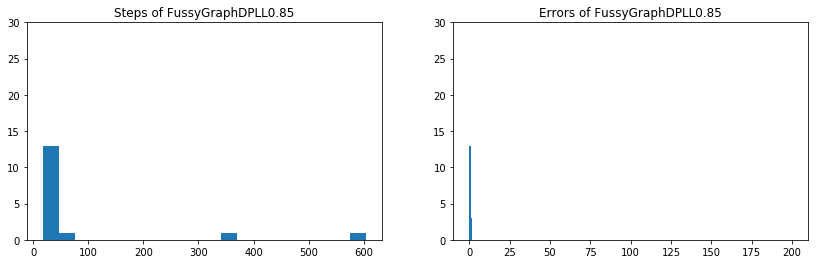

  3%|▎         | 1/30 [00:00<00:04,  6.97it/s]

I (g|~i|q)&(b|d|i|s)&(~h|o|~n|~b)&(m|c|~n|~e)&(s|~l|~r)&(~a|l|~h|r|n|~i)&(e|~r|~c)&(~t|b|~r)&(m|~p|~j|d|~a)&(o|~m|~c)&(j|o|~n|t|~g|~c)&(j|i|p|r)&(~d|~g|o|~m)&(m|n|l)&(s|~l|n|t|~g)&(~i|~n|~j)&(~c|t|f)&(h|~j|~m|~i|a|~e|c|~b|~l|~g|o)&(j|r|~m|~l|~b)&(p|~f|j)&(s|~a|n|o)&(~m|~d|s|a|~t|b)&(b|j|~t|l|n|o|q|~g|~f|~d|~c)&(q|t|p)&(~e|a|~f)&(e|~h|~o)&(r|m|s)&(q|~n|~p|i|r|~c)&(~g|e|~m)&(h|~e|j|p)&(c|m|t|r|~a)&(i|~b|g)&(~l|~g|~f)&(~g|t|~c|f)&(~t|~j|~s|e)&(a|e|i|~t)&(~p|~g|c|~e)&(~f|~h|o|~d|~a|~r|~n)&(j|~r|~e|t|~s|p|~n|i)&(m|p|~a)&(f|g|p|~s)&(~g|~l|~p)&(~l|~c|~b)&(e|i|~t|o|s|~l|~d|~c|~b)&(m|~g|~j|r|~l)&(i|~j|f|~d|~a|r)&(~d|~h|~l|b)&(m|~s|l)&(r|~o|l|j|~t)&(~d|m|j|~i)&(h|~p|~o|~n)&(~t|~f|n)&(c|~i|h|~s)&(~j|~q|e)&(~p|~q|b|m|~d|l|s|~o|~e)&(~q|~a|~e|~b|g)&(~e|c|q|p|~s)&(c|g|~l|p|~e|m)&(~j|~i|~l|r|t)&(n|~e|s)&(i|~n|p)&(l|p|e|~o|r)&(~n|t|j)&(~p|~l|c|~i)&(i|o|~p|~q|~n|~e)&(p|~j|b|~n|c|~d|~a)&(~s|d|~i)&(~m|~o|~j|~i|~l)&(~b|~o|i|~s|~q|~h|~f)&(p|~e)&(p|~o|s)&(d|s|e|~n|c)&(~r|g|~e)&(t|c|d)&(c|~n|~o|j)&(t|~e|~o)&(

 23%|██▎       | 7/30 [00:01<00:02,  7.94it/s]

I (m|~r|p|c|~e|t)&(f|q|~t|~h)&(~n|h|~a)&(~k|h|~c|~f|o)&(d|~l|~h|t|b)&(n|~g|h|f|s)&(c|~m|j|d|~n)&(m|a|~e|p|~b|~n|t|~f)&(e|~j|f)&(~r|m|~s)&(m|~l|e|r)&(q|~m|~l|~h)&(~p|e|~f|~l)&(~e|~b|i|~j)&(~e|~c|~j|r|~i|~l|~h)&(~q|~j|~d|~n)&(~c|~s|n|o|~j|~q|~l|~k|~d|i|p|e|a|~t|b|g|~r|~h|~f|~m)&(i|n|~r|~o)&(~a|q|j|d)&(~h|j|~e|~k)&(~o|~g|p|~d|~c|~b|~j)&(m|p|c|~s)&(n|~c|l|~r|e)&(j|k|q)&(g|l|~p|d)&(f|i|q|p|t)&(~d|~o|~e|~b)&(~f|j|i|o)&(~j|k|~e|~p|~i)&(~m|~s|~k|p|~h)&(s|f|~p)&(r|~e|~l)&(~q|~n|a)&(j|~i|~t)&(~t|q|d|~p)&(s|~o|q|~e|c)&(f|i|~a|e)&(~f|~g|~r|h|i|~s|~m|~c|~t)&(s|~q|~d)&(~c|e|~f|t)&(r|~k|~n|~e|~f|l|~h)&(r|q|a|g|d|~i|e|c|j|p)&(m|~t|q|o|~e|s|i|d)&(m|q|~b|s|~p)&(f|a|n|i|q|~m|~s)&(~a|~n|p|f)&(~l|~h|i|~s|~k|~d)&(~n|~f|~k|~p|a|~m|~h|~i|l|g|e)&(f|~l|n)&(a|o|l|q|~b|e)&(c|f|~n|~o|d|j|s)&(s|e|~m)&(e|~r|p)&(~m|f|i|~o|t)&(~a|d|~q|h)&(~a|~s|~t|~m)&(r|~d|~f|~t|c|i)&(a|p|~d)&(~e|a|q|~s|k)&(i|~f|~k|l|h)&(t|r|d)&(k|~j|t|l|i)&(t|m|s|~g)&(o|~a|t|~j|~c)&(~h|~o|a)&(i|~b|s|~g|~n|e|~d|~k|~h|f|~m)&(m|~k|~d|c|r|~q)&(t|s|~b|~g

 30%|███       | 9/30 [00:01<00:02,  9.38it/s]

I (q|n|~b)&(~l|r|~p|e|d)&(~l|f|~m)&(~q|~h|i|~e)&(~n|~o|~q|i|~c|h|~k|~m|~l|d|~r|~t|~e|~j|~b)&(~d|c|m)&(p|~g|~n|s|m|h|~q)&(~f|~k|h|~e|t)&(~g|h|~l|q)&(~n|~s|~d|~i|~c)&(i|~p|~h|~d|~o|~f)&(b|~i|~m)&(s|j|i|m)&(~s|l|~m|a)&(k|b|~n|~g|~t|~s|i|~o|~h)&(a|~o|e|~h|~d|~i|l)&(~a|s|t|~h|n|~j)&(~t|~f|a|o)&(q|j|o|~d)&(~g|s|n|m)&(t|~f|k|~l|~r)&(j|~l|m|t)&(t|s|~q)&(d|h|r|~b|~s|~f)&(e|g|~h|~j)&(~i|j|~b|f)&(t|f|~g|~m|d|j|b|o|~p)&(~t|~k|s|~b|d|f|~i|~a|~p|n)&(~i|~o|~a)&(n|r|l|a|~g|e|~p|j|~s)&(p|~j|~q)&(n|s|~c)&(h|~e|o|q)&(~b|~m|t|f)&(~t|~b|f|~n)&(~j|e|m|a)&(~p|~r|t|~q)&(q|~k|~t|~o)&(i|l|q)&(~g|~o|d|f)&(f|~n|~k|~g|p)&(a|~o|~f|p|q)&(t|l|~h|~c|a)&(~f|h|r|c)&(~l|c|~k|~f)&(~o|q|f|i|m|~r)&(~r|f|g|~m)&(~k|c|~l)&(c|~n|~i|~a|~o)&(e|~d|m)&(~c|d|~r)&(~n|b|~d)&(c|e|~d|~r)&(~t|~l|n|~r)&(q|s|~c|r|~p|e)&(~a|n|r|~j|~t|d|~e|~c|p)&(h|c|l|g|~p|a)&(j|c|~h)&(r|q|~p)&(s|l|e)&(d|h|~j)&(l|m|~b|q|d)&(j|f|~o)&(n|~q|r|h|b)&(~i|t|~g|~d|~l|~a|q|~m|~j|~p|h)&(p|l|~h)&(~h|i|~d|n)&(~k|~f|s|o|~g)&(~o|~p|~i|~t)&(~g|e|~s|q|t|b)&(t|m|d)&(t|~l|~m

I (p|t)&(t)&(~p)&(~t)&(~p)&(~t)&(p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.191 0.302]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.191 0.302]]]
Fussy cut
I (~n|~m)&(m|~s|~n)&(~n|~m)&(p|~s|n)&(~s|b|n)&(p|~m)&(~m|s)&(m|~b)&(~p|n)&(~n)&(s)&(p|m|n)
P [[[0.528 0.528]
  [0.169 0.15 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.364 0.872]
  [0.303 0.186]
  [0.528 0.528]
  [0.23  0.119]
  [0.528 0.528]
  [0.528 0.528]
  [0.249 0.129]]]
Fussy cut
I (~s|~n)&(~s|n)&(~s|n)&(~n)&(s)&(n)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.5

I (b|t)&(~t)&(b|s|t)&(s|~q)&(t)&(~s)&(~q)&(s)&(b|~s)&(~t)&(s)&(t|q)&(~q)&(~q)
P [[[0.528 0.528]
  [0.77  0.136]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.26 ]
  [0.528 0.528]
  [0.837 0.129]
  [0.514 0.082]]]
Fussy cut
I (s|~q)&(~s)&(~q)&(q)&(s)&(~s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.343 0.456]
  [0.528 0.528]
  [0.252 0.185]]]
Fussy cut
I (~s)&(~q)&(q)&(s)&(~s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.

I (~s)&(s)&(s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~s)&(s)&(s)&(s)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (~q|e|~i|s)&(~s)&(q|c)&(i|~c)&(~q|e|m)&(~e|~q)&(q|m)&(p|~s)&(~p|~c|~i)&(c|~m)&(s)&(~s)&(p|~m)&(~m|s)&(~p|i)&(q|~c)&(~m|~q)&(s)&(p|m)&(s|m)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.099 0.83 ]
  [0.528 0.528]
  [0.467 0.117]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.474 0.121]
  [0.528 0.528]
  [0.528 0.528]
  [0.52

I (s|e)&(s)&(~e)&(s|e)&(~s)&(~s)&(s)&(s)&(e)&(~s)&(e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.281 0.221]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.402 0.179]]]
Fussy cut


 37%|███▋      | 11/30 [00:15<00:43,  2.28s/it]

I (p)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (p)&(g)&(~p)&(g)&(~p|g)&(~g)&(~p|g)&(~p|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.547 0.05 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.685 0.06 ]]]
Fussy cut
I (h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (~d)&(d)&(h)&(~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(p|l)&(~p|l)&(l)&(l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [

I (~k)&(k|d)&(~k)&(~d)&(~d)&(k)&(d)&(k)&(k)&(~d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.161 0.723]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.059 0.267]]]
Fussy cut
I (k)&(~k)&(k)&(k)&(~k)&(~k)&(k)&(k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.82  0.843]]]
Fussy cut
I (k)&(l)&(~k)&(k|~l)&(l|~k)&(l|~k)&(d|~k)&(~k|l)&(k)&(~k)&(~l|~k)&(~d|l)&(l|d)&(k)&(k|~l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.633 0.231]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.219 0.278]
  [0.34  0.238]]]
Fussy cut
I (k)&(l)&(~k)&(k|~l)&(l|~k)&(l|~k)&(~l)&(~k|l)&(~k)&(~l|~k)&(l)&(~l)&(k)&(k|~l)&(k)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
 

I (~o)&(~t|o|p)&(~o|r)&(r|t)&(r|o)&(p|r|o)&(~p|~d|~r)&(r|~d)&(~d)&(r|~d)&(~d)&(h|t)&(~d|o)&(d)&(~p)&(p)&(t|d|~h)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.075 0.463]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.711 0.624]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.113 0.275]
  [0.335 0.137]
  [0.528 0.528]
  [0.87  0.112]
  [0.528 0.528]
  [0.355 0.41 ]]]
Fussy cut


 40%|████      | 12/30 [00:29<01:44,  5.79s/it]

I (~t)&(t|f|~r)&(t|f)&(~f|t)&(r|~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.559 0.216]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.404 0.566]
  [0.528 0.528]
  [0.251 0.332]]]
Fussy cut
I (~t|e)&(~e|~r)&(t|f|~r)&(r|~t)&(~e|f)&(t|e|f)&(r|~e)&(~f|t)&(r|~t|f)&(r|f)&(~e|~t)&(~e|~t)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.197 0.756]
  [0.491 0.171]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.609 0.269]
  [0.528 0.528]
  [0.278 0.446]]]
Fussy cut
I (~f)&(t|f)&(~f|t)&(~t|f)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.211 0.351]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.5

 47%|████▋     | 14/30 [00:31<00:50,  3.14s/it]

I (j|d|r|~l|~c|a|~i|~b)&(~j|~d|~o)&(a|e|i|~r|~f)&(~d|~a|~o|b|h)&(i|~l|~d|~h|c|~g)&(~g|~c|~e)&(~e|~n|~l)&(a|~h|n)&(~b|g|j)&(~s|f|r|~t)&(~g|~c|~t|~m|~a|~q|r|~f|j|~o|~n)&(q|~i|~f|~j)&(a|e|l)&(d|~e|h)&(d|~r|~l)&(~e|~d|h|o)&(i|~n|r)&(b|c|~m|q)&(h|p|~b|~m|a|l)&(b|c|e|f|d|h|~q)&(c|~q|~o|~i|~e|~d)&(a|~b|d|m)&(t|e|j|~a)&(~s|~i|d)&(q|~j|~c|n)&(~r|j|p|t|~h)&(e|~o|~n|~d|f)&(d|~t|g)&(o|e|n|g|~c|d)&(n|c|p|~i|~t)&(q|i|~a|~g)&(~a|~g|~i|b|j|~t|~r|~o|~m|q|~e)&(~i|b|t|p)&(b|~m|~e|h|~t|f)&(q|c|p)&(~h|c|~s)&(s|q|i)&(~g|~c|q)&(~b|p|c|l|~d|~g)&(j|~s|~m|~c)&(~n|~p|~d)&(~d|g|~l|~f|e|~a)&(q|~n|~h)&(f|a|h)&(~r|~d|~o|e|n)&(p|~e|~o|d)&(h|~l|j|~o|i)&(r|~q|t)&(~m|e|~c|~o|a)&(b|c|i|q|~l|~g|~e)&(~e|~i|~n)&(~a|~e|~i|s|f|l|c)&(~h|~n|o|~r|~t)&(q|~e|c|~h)&(~c|g|~a|l|~r|~o)&(o|n|~t|~h|p|~j|l|r|s)&(h|~a|~d|~c|f)&(d|~j|n|~o|~c|~h)&(e|~t|q|~d|~r|c|~n|~h)&(~a|~q|h|~b)&(n|~m|f)&(a|~q|i|~b)&(~j|q|r|~o)&(~r|h|l|e)&(q|~s|~f)&(d|p|~b|s)&(t|~o|j)&(~m|~b|~d|~o)&(b|f|~r|s|~j|~a)&(~c|i|s|m)&(b|~t|~e|~j)&(o|~h|~n|i|t)&(~o|~r|h|q)&(~i|~l

 50%|█████     | 15/30 [00:31<00:34,  2.27s/it]

I (b|~q|~l|~a)&(d|o|t|~k|~g)&(~c|~o|e|f|d)&(~d|~o|~a)&(d|~t|n|e)&(~i|r|o|~k|~m|e|~n|q|~s|~t|c|~d)&(l|~d|~i|~s|t)&(e|~t|l|r)&(s|~b|~i)&(i|r)&(~a|~r|~i)&(~t|c|~i|k)&(r|~k|a)&(~r|g|~d)&(l|~n|~o)&(a|f|o|~p|~c)&(~f|m|~p)&(e|~t|l|m|n|~d)&(a|c|k|~s|o|~n|~m|~l|~b)&(p|o|~q|r|~e|n)&(~d|~p|~f|g)&(~q|l|e|~r)&(a|s|~d)&(g|m|i|~s|~t|~b)&(b|c|~p|~k)&(~q|l|e|k)&(d|l|o|s|~k|~c)&(~k|~b|~e)&(s|~c|~e|~t|~q)&(g|~r|~q|n|~a|~e|~b)&(e|~o|i|t)&(~i|n|o|~q)&(b|d)&(~k|r|~s)&(~m|b|a|~g)&(a|n|~m|~f|~e|~d)&(~g|~t|~r)&(~r|~k|~e|~a)&(~f|~k|r|b|p)&(l|q|o|~p)&(r|s|l)&(~s|~c|e|i)&(b|f|~r|~o|t|~c)&(~e|n|~g|~f)&(p|~c|~f|a)&(s|m|a|b)&(t|~q|~s|e|~p)&(m|~b|n)&(~m|d|~f|~b)&(a|o|m|~c)&(~m|~s|~c)&(~s|a|~l|q|d|f)&(o|q|~n|~p|l)&(b|a|~d)&(n|m|~r|k|~t|~i|c)&(~o|~k|~g|~f)&(~l|~o|d)&(~g|i|n|~o|m|~t|~k|b|f|~c|~s)&(d|o|~m)&(p|a|f)&(i|~f|o|m)&(b|~g|c|s)&(~q|a|n|~m)&(d|~t|q|r|~k|~g|~f)&(~o|m|k|~f|~c)&(~m|~t|o)&(i|~l|~k|~f)&(~e|~l|~p|~n|k)&(~n|e|f)&(~k|n|~q)&(f|n|~i|~g|~e)&(c|~f|r)&(a|k|r|s|~l|t)&(p|~r|~n|i)&(s|t|~o|~l)&(~s|t|~c|~r)&(g|~f|t

 53%|█████▎    | 16/30 [00:31<00:23,  1.70s/it]

I (~r|d|a)&(g|f|~a)&(~a|~c|l|~j)&(l|~q|~j|~g|~e|~d|~b)&(d|~o|~e)&(~d|f|g)&(o|~l|~f|b)&(~j|~c|q|~a)&(~p|l|~h)&(l|o|c|~r|f)&(h|~c|~p|~a|~j)&(~o|~b|a)&(~o|a|~r)&(q|~f|k|b)&(~a|~f|g|o)&(o|~c|~a|~p|~d|~r|j)&(a|~q|p|~m|~e|~c)&(~f|n|e|b)&(~c|~p|~l|~q)&(~c|~r|~q|j)&(~f|q|r)&(c|k|~e|~b)&(g|j|n|~b|l|m)&(b|h|l|~q|r|~d)&(m|~j|~d|~a)&(~f|h|~n|~k|d|~g|~r)&(~d|~f|~e)&(~g|f|k)&(~k|~j|o)&(~p|k|l|c|~e)&(~m|~o|d|~f|~a|~e|~q|~l)&(~p|j|c|~a|~n|m|~q|~r)&(~p|g|q|~e|r|~n|~d)&(l|n|~k|~d)&(a|~r|o|~c)&(~j|d|~h)&(~l|o)&(~h|~o|~a)&(a|c|d|g|~k)&(n|o|q|~k|~h)&(~q|r|e|j)&(h|b|~m)&(b|~k|q)&(~k|d|p|j|~f|a)&(o|~b|~e)&(~j|~o|k|~n|a|l)&(~d|m|~q)&(g|~r|e|~n)&(f|~j|d|~q)&(a|~f|~l|~j|~d|o|r|~q)&(j|~q|~g|c)&(~h|~c|~n|~f|~d)&(c|~a|k|~d)&(c|h|l|m|~p)&(~g|~q|~k)&(a|c|e|f|~p|~o|~m|~j)&(~f|~e)&(d|e|g|j|~o|q|~m|~k|~f)&(o|~g|d|q)&(~f|~n|~q)&(h|~m|~g|~d|~a)&(h|~l|~d|~a)&(~j|~g|c|d|~a)&(~r|~j|l|~o|c)&(g|~q|n|k|~m|l|r)&(~l|m|~d)&(n|~h|k|~f|g)&(~n|~h|r|k)&(~d|~a|m)&(~q|l|p|a)&(~q|~l|~j|~h|~b)&(b|g|l|n|~a)&(a|~l|d)&(g|~q|o|r|~e)&(b|d|l|m

I (~a|r|j)&(h|l|~n|~d)&(~i|~l|e)&(~m|~p|~r|d|~q|j|~e|g)&(e|~c|~m|~n)&(~i|n|l|~k)&(~r|i|d|~h|~l|n)&(~a|~k|b)&(~s|~f|~n|g)&(i|d|~m|~h|e|r)&(j|~k|~m|~f|~a)&(~s|h|t|~f)&(o|g|~f)&(k|~n|~d|~j|e)&(s|t|~n)&(~r|~e|m|~j|~c|~p)&(g|~f|h|~n|~o)&(h|o|~m|~c|b|a|~d)&(a|o|~f|e|~q|~p)&(i|~n|~d|~b)&(~h|~j|g|m)&(d|r|~m|~s)&(t|e|k|~a)&(~i|d|e|~q)&(d|r|~f|t)&(c|p|q|j|k|~f|l|m)&(t|i|o|~k|~s)&(~j|~l|~b)&(o|~t|~j|g|l|~e|a|~i)&(~h|i|~j)&(~k|m|t|b)&(~r|a|~d|s|m|~e|b|k)&(d|~r|a)&(~a|~m|b)&(~j|e|a)&(i|g|q)&(~n|m|h|~i)&(~c|h|~p)&(k|n|~s)&(l|~h|f|~k|~q|s|~b|~e|~i)&(~h|n|s|q)&(~r|~k|i|a|s|~b)&(j|~i|~g|o|l)&(c|t|~p|a)&(~m|~b|~s|d)&(s|~e|~l)&(h|~m|b|~g|~i|f|~d|a|c|~p|~o|~k)&(~c|~k|~b|t|h|~l)&(~d|n|~t|a)&(~s|~h|r|k)&(t|o|d|k|~b)&(j|d|q|~a)&(~o|~a|h|~d)&(~o|~t|~i)&(~c|s|g|~n|~i)&(s|~n|~m|b)&(~i|~q|m|t)&(g|~d|~n)&(~e|o|~l|q|~i|~f|~r|b)&(~d|i|~r|e|~p)&(g|q|~l)&(~m|r|n|~j)&(~o|~j|~p)&(~j|~n|b)&(~m|j|~i|~e|~h|~l)&(j|~m|k|~s|~o|~h|~n|~f)&(~i|a|~c|~m|~p|~h)&(~h|f|d)&(~d|~c|o|s)&(q|o|d|b)&(p|n|~c|d|~q)&(~r|~p|c|l)&(~f|a|c)&(d|r

I (i|~d)&(d)&(d)&(j)&(~d)&(i|d)&(~j)&(i|j)&(~d)&(~i)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.221 0.221]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.087 0.762]
  [0.76  0.014]]]
Fussy cut
I (i|~d)&(~p|~m)&(i|o)&(~p)&(p)&(~i|m|h)&(i|k|m)&(~m)&(p|~d|o)&(i|d)&(p|~o|d)&(~k|o|~h)&(~o|~k|i)&(~p|i)&(k|~o)&(~d|~k)&(p|m)&(~k|~i)&(~o|~k)&(~h|m)&(i|o)&(m)&(~h)&(p|m|~i)&(~i)&(~h|k|d)&(h|~o|k)&(d|i|~p|~o)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.494 0.807]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.082 0.817]
  [0.552 0.772]
  [0.528 0.528]
  [0.156 0.833]
  [0.528 0.528]
  [0.584 0.274]
  [0.528 0.528]
  [0.184 0.895]
  [0.553 0.618]]]
Fussy cut
I (p)&(n)&(~n)&(~p)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (n|

I (~p|t)&(~h|~t)&(p|~g)&(~p|~t)&(g)&(h|~k|o)&(h)&(~o|~g)&(~g)&(~t|~g|k)&(g|k|p|t)&(~k|o|~h)&(~k)&(~h)&(t|~h|g)&(~p|o)&(~g|~k)&(o|t|~g)&(k|o)&(k)&(t)&(~o|k|h|g)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.238 0.885]
  [0.539 0.874]
  [0.528 0.528]
  [0.528 0.528]
  [0.568 0.85 ]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.714 0.451]
  [0.278 0.784]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.88  0.399]]]
Fussy cut
I (~m|l)&(~p|l|t)&(d|k|~t|m|~r|~n|~j|~h)&(i|~d|g)&(h|~s|o|r|~k|~j)&(~r|s|~n|~d)&(i|j|~t|l|s)&(d|~t|~r|~h)&(~p|r|~m)&(h|i|j|k|~s|n|m|~d)&(l|p|~n|~g)&(h|m|~r|p|~o|~k|~j|~d)&(~l|g|o|s|i)&(~t|~n|~p)&(~h|l|~m)&(~s|d|g)&(j|~l|p)&(~s|h|~k|o)&(s|~r|~m)&(~i|m|h)&(p|r|~d)&(m|~l|k|i)&(r|~l|~m)&(p|~d|o)&(l|p|h|i|o)&(p|r|i|~m|l)&(i|j|n)&(~i|~g|~r)&(~t|~g|k)&(i|d|~l)&(~o|d|p|s)&(g|k|l|p|t)&(~k|o|~h)&(i|k|~t|~m|~g)&(~o|~k|~t|i)&(t|~r)&(s|~p|r|j|i)&(k|~o)&(r|~d|~k)&(n|~o|s|~k|~i)&(i|k|~t|m|n)&(~h|p|~j)&(i|r|~l|~j|~g|

 67%|██████▋   | 20/30 [00:42<00:19,  1.92s/it]

I (~k|~q|~g|c|~l|n)&(~q|s|j)&(~l|s|~g)&(o|f|a|~c|~b|~e|~m|~l)&(p|d|g|~o)&(o|c|b|j)&(o|~n|~p)&(~t|q|a|h|~k)&(h|~s|~t|~o|c|j|i)&(b|n|~k)&(~j|~d|q|~f|s)&(i|q|a|k)&(j|q|h|~k)&(~m|~j|~g)&(~c|b|l|k|s|~q|i|~a)&(i|~o|~t|~c|n|~g|~q|r)&(~c|~i|s)&(~s|~d|~a|q)&(~g|n|b|s|~d)&(~g|i|~d|h|q)&(~g|m|~h)&(~q|a|~l|d)&(o|d|~b|~g)&(~k|j|p)&(~s|~t|~l)&(~f|o|~a|~j)&(t|~f|~s|~n|~h|~m|~c)&(~j|~a|p)&(~b|d|c|~p|~n|f|~h)&(~j|q|~i)&(~t|~q|a)&(~q|~d|k|o)&(~e|~c|~o)&(s|r|~d|~n|m)&(~d|j|n|~q)&(t|~n|~d)&(~l|q|~s)&(q|~n|~p|~a)&(~i|k|e|~h|~t|n|~o|f|q|s|~b)&(~j|e|~d)&(l|r|~a|p)&(i|~a|g|l|t|k)&(~r|~l|~n)&(a|~r|~k|f)&(~g|~f|p|c|a|~q)&(f|k|~h|~a|p)&(j|b|c|i|~t)&(~q|e|n|~o|~r|~t|~k)&(i|~e|~m|~g)&(~h|p|~n|~c)&(~n|~f|d)&(t|a|s|g|k|~d|~h|~n|~l|~m)&(e|h|~d|~c|m|l)&(~q|~k|~p)&(~p|o|a|h)&(~q|~e|d|b|s|~o|~l|~r)&(j|~c|s|n)&(k|d|r|~g|p)&(d|~j|b)&(~e|~b|m|t|~c)&(h|~l|~g|p|c|m)&(f|j|s)&(c|i|e|b)&(i|l|~h|~c|~q|o)&(~k|j|p|r)&(r|q|~m|~g)&(e|j|q)&(b|r|h)&(t|~s|~j|e|h|~c)&(f|r|~t|i)&(~h|~b|q|~f)&(~d|f|h)&(~m|t|k|~n|~s|~b|g|h|~q|p)&(k|~q|~s|c

 77%|███████▋  | 23/30 [00:42<00:07,  1.09s/it]

I (~t|r|~e|o)&(~n|b|q|k)&(c|n|d|k|~f)&(o|h|l|d|~j)&(~k|~j|~l)&(q|~m|~n|r)&(~j|~p|~b|c|~s|m|~f|g|~k)&(~d|g|~q|a|j)&(p|a|~n)&(m|~n|o|t|~c|a|s)&(p|i|~f|d|a)&(s|p|~o|h|d|~e|~c|m|q|a|k)&(b|~r|~m)&(~p|~e|~n|~i)&(r|f|~s|n|h|~d)&(p|q|l|~g|n|~e)&(r|~m|q|a)&(~d|o|i)&(~h|~j|e|b)&(e|~g|k|~t)&(f|q|~h)&(r|~b|l|j|i|~s|~g|o|n|~k)&(~m|~d|~k|s|~q|~b|~i)&(~l|f|i|~p)&(i|r|a|h|d)&(n|h|~r)&(g|n|~b|~a|~d|~c)&(~c|~n|t|~o|~d|e|~p|a)&(n|~r|~d|~e)&(b|~f|o|~c)&(q|~m|h|r)&(n|~g|~h|~t)&(~h|l|~q|~j|~i|d|~r|b|a|~k)&(~q|~r|~d|a)&(~k|~j|t|~h)&(~l|s|~n|~t|~o|~m|~g)&(n|p|t)&(~c|~n|r)&(~o|e|~s|~m)&(~k|~h|g|~m)&(m|~i|~j|q|~l|~p|t|e)&(~b|~m|h)&(~e|~h|~b)&(b|q|~m|~i|~n|~d)&(f|~p|e|~t|~q)&(p|~f|i|~q)&(~k|t|~s|~j)&(k|p|o)&(l|~d|~s|q|~k)&(l|~g|~b)&(~b|~l|~d|~k|~r|m|~o|j|~g|f|e)&(a|e|~t)&(f|~o|~b|~c|a|~p)&(~h|~o|~f)&(~k|s|p|~g|~d|n)&(~q|t|n|~e)&(t|p|~e|~o)&(q|l|b)&(~o|m|~d|~i|~r|~s|~q|k)&(e|r|~l|~d)&(~k|~q|~d)&(~n|q|~a)&(~c|e|~h|i)&(c|~s|t)&(j|f|~n|l)&(~e|~l|g|q|p|~b)&(b|~q|~c|p|f)&(~a|s|q)&(s|~l|~e)&(~t|~g|~k|~h)&(k|~i|~e|b|p|~

 80%|████████  | 24/30 [00:42<00:04,  1.23it/s]

I (i|s|p|~e|j)&(~i|m|h|j|k|f|a|l|~d|e)&(f|~l|n|d|t|j|e|~i|q|c|h)&(g|l|o|e)&(r|~h|~i)&(o|a|~m|~g|~f|i)&(~a|~n|~f|q|~e)&(~r|~l|~a)&(q|t|e)&(k|~g|o)&(r|~l|~s|j|~o|~g)&(~e|q|p|d)&(l|~o|~c|~q)&(~l|~k|t)&(k|f|a)&(~h|~k|q|g|~d|n)&(d|j|~c)&(p|j|a)&(c|i|~n)&(n|p|g|d|r)&(~a|l|~n|s|~h|~k)&(~t|~k|~p)&(~c|i|q)&(k|h|~t|l)&(~d|m|~f|~h)&(q|k|~i|~o|~g|~d)&(~p|l|~i|~a|~q|g|~n|~e)&(d|a|f)&(~f|~m|~n|a|~q|~l|g|~r)&(~n|r|e|~k|~l|~h|~t)&(h|a|~t)&(a|~m|e)&(p|l|~a)&(s|~m)&(~r|~t|~n|f|c|s)&(g|~r|~o|~f)&(d|s|~m|~f)&(~o|~s)&(k|~e|~d)&(~k|~j|~s|e|~i|g|~d|q)&(~r|~p|e|l|m)&(~p|~t|~k)&(~g|~a|~s|j|~t)&(e|~r|~o|~h|~s|f)&(r|c|~n|~p|a)&(m|s|~f)&(n|r|~a|~i|~o|~m)&(~m|h|~n|e)&(~g|~c|s|~r|~k)&(~t|~m|~r|k|e|j)&(c|d|~q)&(~k|~c|j)&(~q|~r|~m)&(~q|s|~l|~p|a|i|~d)&(d|n|~m)&(~m|e|l)&(f|~s|i|~g|~j|~h|o)&(~k|~e|r)&(m|o|t|~p)&(n|~g|~m|~c)&(k|e|~s|d)&(~n|~c|~d)&(s|t|~c)&(a|h|j|~c|n|~i|~l|t)&(~s|~h|~g)&(~f|~r)&(r|~m|~g|i|p|c)&(~d|c|~s|~l|h)&(o|~g|~a)&(~g|~r|~s|~t|k)&(~t|c|~s)&(c|~o|l|m|~g)&(~e|g|h)&(~f|n)&(p|m|o)&(~i|q|~c)&(d|n|q)&(~q|

 83%|████████▎ | 25/30 [00:43<00:03,  1.35it/s]

I (l)&(~l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (l)&(l)&(~l)&(l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.751 0.005]]]
Fussy cut
I (l)&(~l)&(~l)&(~n|l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.13  0.288]
  [0.528 0.528]
  [0.141 0.897]]]
Fussy cut
I (l)&(l)&(~l)&(~l)&(~n|l)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.207 0.194]
  [0.528 0.528]
  [0.147 0.892]]]
Fussy cut
I (~n)&(n)&(~n)&(n)
P [[[0.528 0

100%|██████████| 30/30 [00:48<00:00,  1.08it/s]

I (p|s|~l)&(d|j|~r|~l|~t|b)&(~e|~r|~f|~j)&(~o|b|~a|~r)&(~p|~b|n)&(k|q|~n|s|~f|g|~j|~i|p|m)&(m|a|t|p)&(l|g|h)&(~n|g|~d|c)&(e|s|~n|j)&(~h|q|a|~m|t|~d|~n)&(~i|~b|~s|~k|h)&(o|~c|~f|t|e|~q|k|~m|i|~r|n)&(p|n|~r|e)&(h|c|~l)&(c|~r|t)&(~f|~g|m)&(m|t|j|e|~n|~q|i|p)&(c|f|n)&(~k|e|g|b)&(~o|~e|~l|k|~b)&(~o|~l|~t|~q|n)&(~q|~g|i|h|c)&(~q|t|~m|e)&(i|a|~k|~d|b|~e)&(~c|~a|~h|q)&(g|~e|c|~s)&(~l|~s|~r)&(j|i|~p)&(~a|~f|s)&(~g|j|~k|~b|~c|~i|~f)&(s|b|~o|~e|~l|~p|~d)&(~i|h|g|~l|~o|~t)&(~l|~e|~q|~s)&(r|c|~e|g)&(~d|~b|~j)&(~g|m|~e)&(~l|i|~j)&(~f|g|~s|~a)&(~t|~e|a)&(~s|r|~o|~b)&(p|~m|q)&(~o|~m|n|j|g|~e|~p|s)&(~i|c|h|~l|t|~q|f|d|p|~b)&(h|~g|~q|~m)&(~k|s|~c|~e|f|~m|g|r)&(o|~r|~l|m|~h)&(~g|h|p|j)&(~m|h|q|~n|g)&(~l|i|~k|t)&(n|j|g|~m|~l|e|i)&(~l|~h|~o|~e)&(n|~i|~j|~c)&(d|l|c|s)&(f|~c|k)&(q|~h|j|s|n)&(~n|~h|m|q)&(~d|o|~f)&(s|~i|~o|a|r|~e)&(~d|l|~s|~a|b|~n)&(~b|~c|~a|~h)&(a|~b|~r|~l)&(q|b|l)&(~g|~s|b|~n|j)&(~l|s|h|~b|~q|~g|r)&(~o|s|i|f)&(s|~a|r|b)&(~o|h|j)&(s|t|l)&(e|~h|~d|~c|j|~s)&(h|~i|~s|~d|b|t)&(b|g|n|m|j|~q)&(~t|~

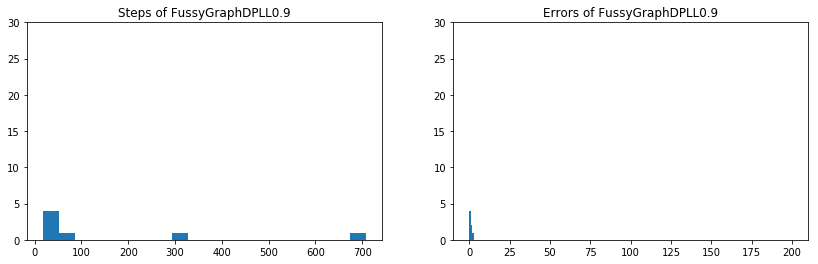

In [45]:
print_all(30, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  5.47it/s]


Within 1e3 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.30; stdev step: 5.04; avg error: 0.20; stdev error: 0.40


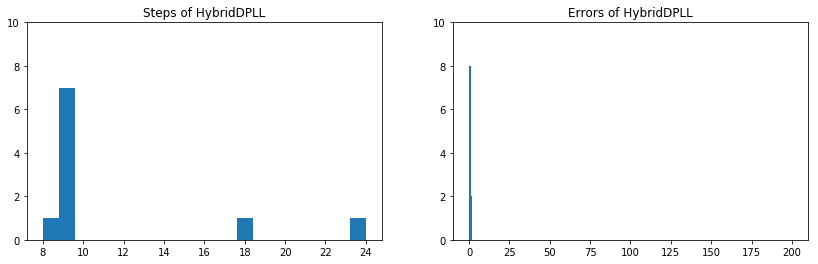

100%|██████████| 10/10 [00:00<00:00, 687.90it/s]


Within 1e3 steps solved 10 problems out of 10
#Sats: 10; avg step: 17.00; stdev step: 12.50; avg error: 0.70; stdev error: 0.90


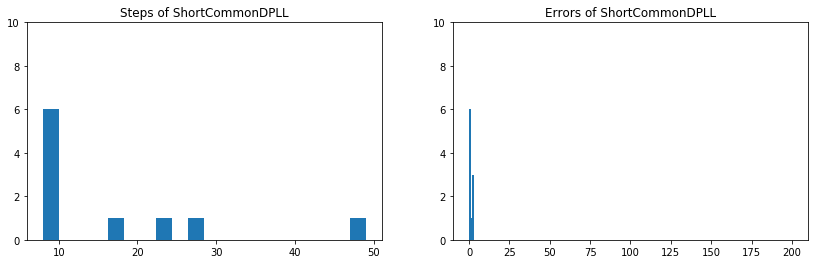

100%|██████████| 10/10 [00:01<00:00,  5.22it/s]


Within 1e3 steps solved 10 problems out of 10
#Sats: 10; avg step: 11.30; stdev step: 5.04; avg error: 0.20; stdev error: 0.40


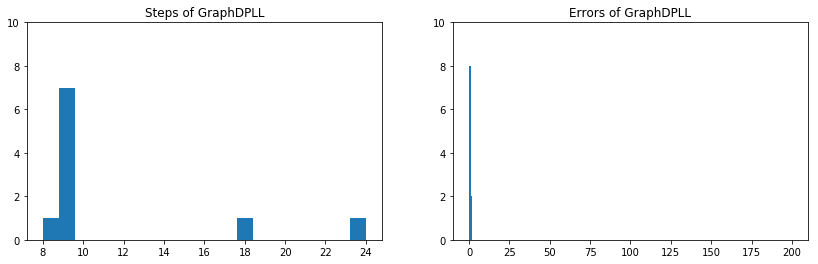

 10%|█         | 1/10 [00:00<00:02,  3.32it/s]

I (d)&(~d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (h|~g|~f|~e)&(~d|~f|~g)&(~c|~a)&(c|~h|~g|~d)&(~h|f|~a)&(~e|a|~g|~h)&(e|~c|f)&(c|h|d|e)&(~a|~d|f)&(~h|a|~f|~e|~c)&(~e|c|f)&(e|a|~d)&(f|e|~d)&(h|e|g|f)&(e|g|h|~f|~c)&(~f|~d|c|h)&(~d|~f|e|~c|g|~h)&(~h|f|a|c|~d)&(~g|e|~h|f|d|a)&(e|h|d|g)&(a|g|~h|~f|~e|~d|~c)&(~c|e|h|d)&(~c|g|~a|~f)&(g|c|~a)&(~g|~h|f|a|c|d)&(c|f|g|~h|~e|~d|~a)&(c|d|e|f|h|~g)&(g|h|~f|~e|~d|~c|~a)&(~c|~d|~h|~f)&(h|c|g)&(c|~a|e|h)&(~d|~c|e|h)&(~d|~a|f|e|g|~c)&(~a|~c|h|~f|~e)&(a|e|f|g|~h|~d|~c)&(d|f|g|~e|~c)&(h|e|~a)&(~g|~e|~f|~d)&(f|~c|~h|a)&(c|e|~f|d)&(c|d|~a)&(~h|~f|~e|~d|~c)&(g|~a|~h|f)&(a|f|g|h|~e)&(d|g|a)&(a|c|f|~g|~d)&(d|e|h|~g)&(c|e|h|~g)&(~e|~c|~g|~d)&(f|g)&(~d|a|~f|~g)&(c|e|g|~a|~h|~f|~d)&(~c|h|~d|e)&(~a|~c|~e|f)&(~a|~g|c)&(~g|~c|f|d)&(c|~e|~a|d)&(e|f|h|~g|~a)&(~f|a|d)&(e|d|a|~h)&(g|~h|e|~f)&(~a|e|d|h|f)&(~e|a|~h|c|~d)
P [[[0.178 0.441]
  [0.528 0.528]
  [0

 20%|██        | 2/10 [00:00<00:03,  2.61it/s]

I (e|~c|f)&(~f|~e|~c)&(~f|~e|~c)&(~e|c|f)&(e)&(e|f)&(~c|~f|e)&(c|f)&(c|e)&(~f|~c)&(~f|~e|~c)&(~f)&(~c|f)&(~e)&(f)&(c|f)&(~f|e)&(c|~e)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.348 0.411]
  [0.528 0.528]
  [0.309 0.298]
  [0.311 0.305]]]
Fussy cut


100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


Within 1e3 steps solved 9 problems out of 10
#Sats: 9; avg step: 10.11; stdev step: 3.51; avg error: 0.11; stdev error: 0.31


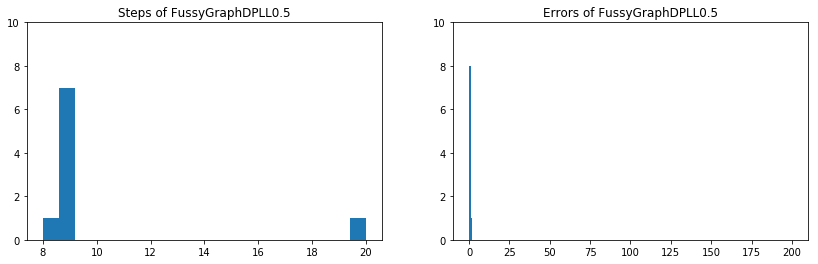

 10%|█         | 1/10 [00:00<00:02,  3.73it/s]

I (d)&(~d)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (c)&(~c)
P [[[0.528 0.528]
  [0.528 0.528]
  [0.16  0.16 ]]]
Fussy cut
I (h|~e|~b|~f|~g)&(~d|~f|~g)&(h|~a|b|g|e|~c|d|~f)&(~c|~a|~b)&(c|~b|~g|~h|~d)&(~b|~h|~a|f)&(~e|b|d|g|~h|~a|c)&(~e|a|~g|~h)&(b|d|a|h|f|~e)&(e|~c|f)&(c|h|d|e)&(~g|e|b|h)&(b|~c|~h|a|~f|~e|g|~d)&(~a|~d|f)&(~h|a|~f|~e|~c)&(~e|c|f)&(e|a|~d)&(f|e|~d)&(h|e|g|f)&(e|~f|~b|g|~c|h)&(~f|~d|c|h)&(b|~h|c|f|e|d|a|g)&(a|b|h)&(~d|~f|e|~c|g|~h)&(e|f|b|h|g|a|~c|~d)&(b|~g|a)&(g|a|e|c|~d|f|b|h)&(~h|f|a|c|~d)&(~g|e|~h|f|d|a)&(b|g|c|e)&(e|h|d|g)&(~e|~d|~c|b|~g|~f|~a|h)&(a|~h|g|~f|~d|~b|~c|~e)&(g|b|~a)&(~c|e|h|d)&(~g|~c|~d|b|~f|~e|h|~a)&(~c|g|~a|~f)&(g|c|~a)&(~g|~h|f|a|c|d)&(~b|g|~d|~a|f|~h|c|~e)&(e|~g|d|h|~b|c|f)&(~a|~e|~f|~d|~c|h|g|~b)&(~c|~d|~h|~f)&(h|~b|c|g)&(c|~a|e|h)&(~d|~c|e|h)&(~d|~a|f|e|g|~c)&(~f|a|g|~c|b|~h|~e)&(~f|b|a)&(~a|~c|h|~f|~e)&(~g|~c|~f|b)&(b|c|f|h|g|~e|a)&(e|~h|~b|a|g|~d|~c|f)&(~f|~a|~h|e|c|d|~g|b)&(f|~c|g|~b|~e|d)&(~a|e|h|~b)&(~g|~

 50%|█████     | 5/10 [00:00<00:00,  5.33it/s]

I (h|c|~g|~f|b)&(~h|~e|~a|~b)&(~g|~b|e|~c)&(f|h|~g|e)&(~a|~f|d|b|~g)&(~e|d|h|g|~c|f|a)&(~b|g|~c)&(b|~d|f|g|~a|h)&(d|~e|~a|~h|~f|~b)&(a|~h|~g|~f)&(f|~g|c|~b)&(d|~b|f)&(e|g|h|~c)&(~d|~b|~g|f)&(~b|~c|d|h|~e)&(d|f|~g|~c)&(b|g|~h|a|~d)&(~b|h|a|~g|~c)&(e|a|~g|~f)&(~f|~d|h)&(d|~a|b)&(~a|~d|~f)&(~a|b|g|~h|~e|d)&(~f|~c|e)&(~h|c|a|b|d|~g|~e)&(a|d|~f|e|~g)&(~g|~e|d|h|c|~f)&(~e|~b|h|f|~g|a|c|~d)&(g|d|b|f|h)&(b|h|c|~e|d|~g|f|a)&(~g|e|a)&(f|~a|g|~d)&(~b|~f|~g|~h|d)&(f|b|e|~g|~d)&(~e|~a|c|f)&(~d|~c|f|a|b)&(h|f|g|~a)&(~a|~c|h|~g|~e)&(~f|b|~g|c|~a)&(~g|a|b|~c)&(g|~b|c|e)&(g|~d|~h)&(a|h|d|f|~b|e|g)&(e|c|~f|~d)&(d|~c|a)&(g|b|~c)&(~a|~b|~d)&(~c|a|~g)&(a|h|c|~g)&(h|a|~c|~f)&(h|~e|c)&(~g|~e|c|b)&(~b|f|e|~c|~h)&(d|c|e|~f)&(~c|f|d|~g|~e)&(d|~h|g|e)&(~f|~a|e|h)&(~c|~a|~g|f|e)&(~e|~h|d|~a|f)&(~g|~f|a|c|e|~d|h|b)&(h|~g|~f)&(b|~g|~e|~a|f|c|h)&(g|h|f|~b|d)&(~g|~e|h|d|b|f)&(~b|~e|~g|f|~d)&(e|d|c|a|f)&(~h|~b|d|~g|~e)&(b|~a|c|d|h)&(~d|b|e|~f)&(g|h|~e)&(~b|f|~a|~g|~c|e|h)&(~e|d|~g)&(c|e|~g)&(h|~a|~d)&(e|~g|~b|c)&(~d|~

100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


Within 1e3 steps solved 7 problems out of 10
#Sats: 7; avg step: 10.43; stdev step: 3.92; avg error: 0.14; stdev error: 0.35


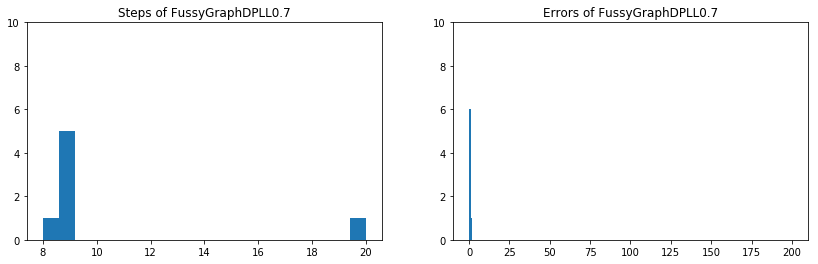

 30%|███       | 3/10 [00:00<00:00, 25.48it/s]

I (~b|~c|~a|~d|e)&(g|~d|~e)&(d|~e|~a)&(~a|~d|~f)&(d|~g|h|f)&(~e|a|d|~h|~g)&(g|e|f|~b|~c|h|~d)&(~c|h|e|g|~a)&(~h|f|a|d)&(~g|~f|~b)&(~d|~e|g|b|~h|c|f|a)&(c|~e|~g|b|d)&(g|d|c|h|~f|~a|b|e)&(~e|a|~f)&(~e|~b|c|~a|~g|d|~f)&(~f|~d|~g|~a)&(b|~c|f|~e|~h)&(~a|f|~b)&(d|~f|g|e|h|~a)&(~e|~b|g|~a|~c)&(e|b|a|~h|f|c)&(a|d|b|~c|h|~g)&(h|a|~c|~e)&(~f|~g|e|b)&(f|g|h)&(~b|f|~a|g|h)&(~e|~c|g)&(h|~b|~e)&(b|~d|h)&(g|a|~e|~f|b)&(b|d|~c|a)&(~b|d|a|~f)&(~h|b|~f|g)&(~e|~h|~c|~d)&(~e|~f|~h|~c|d)&(h|a|c|b)&(~h|~f|~c|g|~b|e)&(b|f|~e)&(~e|a|c|~b)&(~f|a|~e|~h|g|d)&(~a|f|~h|c|e)&(~b|~e|~f|h)&(~e|a|~f|~h|c|g|d)&(d|b|~c|~h|~g|~a|f|~e)&(~f|b|~c|d)&(~a|f|~c|~e|b|~g|~h|d)&(~h|~f|~g|~b)&(g|c|e)&(~d|a|g|~e|c)&(f|b|h|d)&(~g|b|h|c)&(~h|f|d|c)&(b|~g|c|a|f)&(~b|d|~h|~g|~e|f|a|c)&(~e|b|~d|~h|~a|~f|~g|~c)&(~e|g|f)&(c|e|~h|~d|~g|a)&(b|e|f|~a|c)&(e|~d|h|~c|f|a|~g|b)&(g|b|e|a)&(d|~h|e)&(~e|f|~b)&(a|~f|d|e|g)&(~b|d|~f|h|~c|~g)&(c|g|~a)&(~e|~g|~f|d|c|~a|~b|h)&(a|~b|~e)&(e|~h|~c|~b)&(f|~d|e|h)&(~e|~c|~h|b|d|~g)&(~d|g|f)&(f|~d|b)
P [[[0.6

100%|██████████| 10/10 [00:00<00:00, 18.93it/s]


I (a|~b|~g|~h|c|~f)&(~c|h|~e)&(~h|e|~b|~g|~f|~c)&(~g|~a|~b|~d|~f)&(f|~e|~g|h|b)&(e|c|~h|~d)&(~h|b|~a|d|~e|f|g|~c)&(~e|~a|g|h|c|f|~d|b)&(h|~g|~d)&(~d|~c|~g)&(~e|~d|~c|f)&(~f|~a|~c|~b|~h|e|g|~d)&(~f|~d|b|a)&(~c|~e|d|~g)&(~h|~g|~b|e|d)&(c|~b|a|e)&(h|~c|~e|g|f|d|b)&(d|~a|e|c|f|h)&(~d|a|~e|f|~c)&(g|f|~e|~c|b|h|~d|a)&(~a|~g|~d)&(f|c|~e|~h|b)&(h|~b|d)&(g|~a|~c)&(g|~c|~a|~f|~d|~h|b)&(~a|c|~g|~f|h|~b)&(a|~h|~b|~f|~e|~d)&(c|d|a)&(a|f|b|d|c|e|h|g)&(h|~d|~f|e)&(d|~g|a|~b|~f|h|c)&(d|h|f)&(b|d|g|c)&(a|~b|e|~c|g|f)&(~e|~g|f|b|~a)&(~a|e|~g|~h)&(b|d|~g)&(f|~d|~a|c|~h|~g|~e)&(h|~e|a|~g|b)&(~b|e|~c|~g)&(~h|~g|e)&(b|~g|f)&(c|d|e)&(~f|~h|c|~a|g)&(~e|~a|~f)&(~e|~d|~a|b)&(~h|a|d)&(e|~h|g|~b|~f|~d)&(h|~c|b|~f|~d|~g|~a|e)&(~b|~e|g|~d|h)&(~f|~e|~h|d|b|~c)&(e|g|~a|~c)&(~h|a|d|c)&(b|~d|~a)&(~f|~a|~d|~h|e|~c|~g|~b)&(d|a|~f)&(~g|~f|d|~h|a|b)&(~g|~h|c|~a|e)&(e|~a|~h)&(c|f|~g)&(~h|~c|~d|a|f|~e|~b|~g)&(h|~a|d|e)&(b|~d|e|g|h)&(~f|~d|g|~e|~b|~a|h|~c)&(~e|f|g|~b)&(d|~c|~b)&(~c|~g|~e|b)&(~a|b|e)&(~f|c|g|~b)&(b|g|d)&(b|~c|

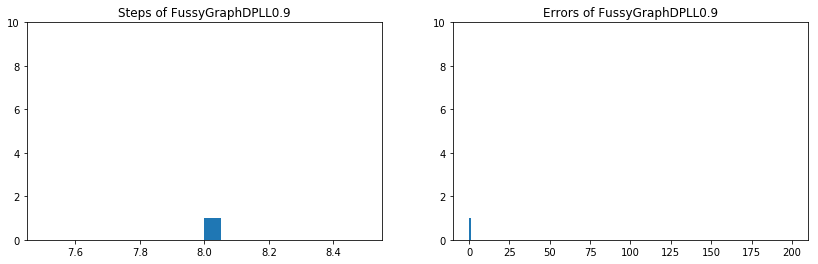

 60%|██████    | 6/10 [00:00<00:00, 26.05it/s]

I (~b|~c|~a|~d|e)&(g|~d|~e)&(d|~e|~a)&(~a|~d|~f)&(d|~g|h|f)&(~e|a|d|~h|~g)&(g|e|f|~b|~c|h|~d)&(~c|h|e|g|~a)&(~h|f|a|d)&(~g|~f|~b)&(~d|~e|g|b|~h|c|f|a)&(c|~e|~g|b|d)&(g|d|c|h|~f|~a|b|e)&(~e|a|~f)&(~e|~b|c|~a|~g|d|~f)&(~f|~d|~g|~a)&(b|~c|f|~e|~h)&(~a|f|~b)&(d|~f|g|e|h|~a)&(~e|~b|g|~a|~c)&(e|b|a|~h|f|c)&(a|d|b|~c|h|~g)&(h|a|~c|~e)&(~f|~g|e|b)&(f|g|h)&(~b|f|~a|g|h)&(~e|~c|g)&(h|~b|~e)&(b|~d|h)&(g|a|~e|~f|b)&(b|d|~c|a)&(~b|d|a|~f)&(~h|b|~f|g)&(~e|~h|~c|~d)&(~e|~f|~h|~c|d)&(h|a|c|b)&(~h|~f|~c|g|~b|e)&(b|f|~e)&(~e|a|c|~b)&(~f|a|~e|~h|g|d)&(~a|f|~h|c|e)&(~b|~e|~f|h)&(~e|a|~f|~h|c|g|d)&(d|b|~c|~h|~g|~a|f|~e)&(~f|b|~c|d)&(~a|f|~c|~e|b|~g|~h|d)&(~h|~f|~g|~b)&(g|c|e)&(~d|a|g|~e|c)&(f|b|h|d)&(~g|b|h|c)&(~h|f|d|c)&(b|~g|c|a|f)&(~b|d|~h|~g|~e|f|a|c)&(~e|b|~d|~h|~a|~f|~g|~c)&(~e|g|f)&(c|e|~h|~d|~g|a)&(b|e|f|~a|c)&(e|~d|h|~c|f|a|~g|b)&(g|b|e|a)&(d|~h|e)&(~e|f|~b)&(a|~f|d|e|g)&(~b|d|~f|h|~c|~g)&(c|g|~a)&(~e|~g|~f|d|c|~a|~b|h)&(a|~b|~e)&(e|~h|~c|~b)&(f|~d|e|h)&(~e|~c|~h|b|d|~g)&(~d|g|f)&(f|~d|b)
P [[[0.6

100%|██████████| 10/10 [00:00<00:00, 25.52it/s]
/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/michal/.virtualenvs/deepsat/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


I (a|~b|~g|~h|c|~f)&(~c|h|~e)&(~h|e|~b|~g|~f|~c)&(~g|~a|~b|~d|~f)&(f|~e|~g|h|b)&(e|c|~h|~d)&(~h|b|~a|d|~e|f|g|~c)&(~e|~a|g|h|c|f|~d|b)&(h|~g|~d)&(~d|~c|~g)&(~e|~d|~c|f)&(~f|~a|~c|~b|~h|e|g|~d)&(~f|~d|b|a)&(~c|~e|d|~g)&(~h|~g|~b|e|d)&(c|~b|a|e)&(h|~c|~e|g|f|d|b)&(d|~a|e|c|f|h)&(~d|a|~e|f|~c)&(g|f|~e|~c|b|h|~d|a)&(~a|~g|~d)&(f|c|~e|~h|b)&(h|~b|d)&(g|~a|~c)&(g|~c|~a|~f|~d|~h|b)&(~a|c|~g|~f|h|~b)&(a|~h|~b|~f|~e|~d)&(c|d|a)&(a|f|b|d|c|e|h|g)&(h|~d|~f|e)&(d|~g|a|~b|~f|h|c)&(d|h|f)&(b|d|g|c)&(a|~b|e|~c|g|f)&(~e|~g|f|b|~a)&(~a|e|~g|~h)&(b|d|~g)&(f|~d|~a|c|~h|~g|~e)&(h|~e|a|~g|b)&(~b|e|~c|~g)&(~h|~g|e)&(b|~g|f)&(c|d|e)&(~f|~h|c|~a|g)&(~e|~a|~f)&(~e|~d|~a|b)&(~h|a|d)&(e|~h|g|~b|~f|~d)&(h|~c|b|~f|~d|~g|~a|e)&(~b|~e|g|~d|h)&(~f|~e|~h|d|b|~c)&(e|g|~a|~c)&(~h|a|d|c)&(b|~d|~a)&(~f|~a|~d|~h|e|~c|~g|~b)&(d|a|~f)&(~g|~f|d|~h|a|b)&(~g|~h|c|~a|e)&(e|~a|~h)&(c|f|~g)&(~h|~c|~d|a|f|~e|~b|~g)&(h|~a|d|e)&(b|~d|e|g|h)&(~f|~d|g|~e|~b|~a|h|~c)&(~e|f|g|~b)&(d|~c|~b)&(~c|~g|~e|b)&(~a|b|e)&(~f|c|g|~b)&(b|g|d)&(b|~c|

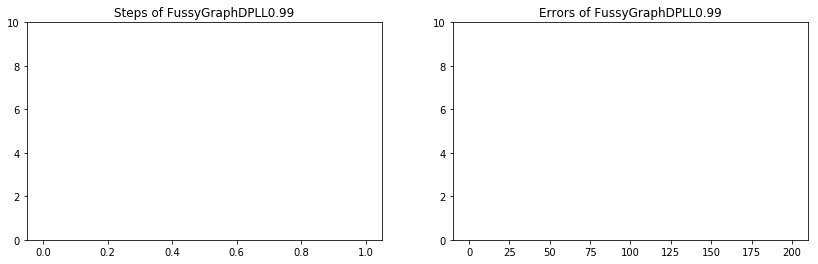

In [43]:
print_all(10, 200, 8)

In [ ]:
print_all(10, 200, 10)

In [ ]:
print_all(10, 200, 12)

In [ ]:
print_all(10, 200, 14)

In [ ]:
print_all(10, 200, 16)

In [ ]:
print_all(10, 200, 18)

In [ ]:
print_all(10, 200, 20)

In [ ]:
print_all(10, 500, 25, light=True)

In [ ]:
print_all(10, 500, 30, light=True)

In [ ]:
print_all(10, 1000, 40, light=True)

In [ ]:
print_all(10, 1000, 50, light=True)

In [ ]:
print_all(10, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 90, light=True)

In [ ]:
print_all(10, 1000, 40, light=True)

In [ ]:
print_all(100, 1000, 70, light=True)

In [ ]:
print_all(100, 1000, 60, light=True)